In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
#import sys
#sys.path = [x for x in sys.path if x !='/private/home/costajussa/.local/lib/python3.8/site-packages' ]
import os

import torch
#torch.cuda.set_device(1)
#torch.cuda.current_device()

import warnings
from pathlib import Path

from wrappers.multilingual_transformer_wrapper import FairseqMultilingualTransformerHub

from fairseq.data.multilingual.multilingual_utils import (
    EncoderLangtok,
    LangTokSpec,
    LangTokStyle,
    augment_dictionary,
    get_lang_tok,
)

import alignment.align as align

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pandas as pd
import numpy as np
import fairseq

import logging
logger = logging.getLogger()
logger.setLevel('WARNING')
#warnings.simplefilter('ignore')

from dotenv import load_dotenv
load_dotenv()
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
def merge_contributions(source_sentence, target_sentence, word_bpe_contributions):
    target_words_list = ['</s>'] + ''.join(target_sentence[1:]).replace('▁', ' ').split()
    source_words_list = ''.join(source_sentence[:-1]).replace('▁', ' ').split() + ['</s>']
    words_list = source_words_list + target_words_list
    word_i = 0
    word_to_bpe = [[] for _ in range(len(words_list))]
    for bpe_i, token in enumerate(source_sentence + target_sentence):
        if token == '</s>' or token.startswith("__"):
            word_i += 1
        if token.startswith("▁"):
            word_i += 1
        word_to_bpe[word_i-1].append(bpe_i)
    words_contrib = []
    for word in word_to_bpe:
        word_contrib_sum = 0
        for subword in word:
            word_contrib_sum += word_bpe_contributions[subword]
        words_contrib.append(word_contrib_sum)
    return words_list, words_contrib

## Load model

Choose model size (small/big), and data mode ()

In [252]:
model_size = 'small' # small (412M) /big (1.2B)
data_sample = 'interactive' # generate/interactive
teacher_forcing = True # teacher forcing/free decoding

In [253]:
# Paths
# Checkpoint path
#ckpt_dir = Path(os.environ['M2M_CKPT_DIR'])
#ckpt_dir = Path(os.environ['/large_experiments/nllb/mmt/h2_21_models/flores125_v3.3/en_to_many_to_en/v3.3_dense_hrft004.mfp16.mu100000.uf4.lss.enttgt.tmp1.0.shem.NBF.warmup8000.lr0.004.drop0.0.maxtok2560.seed2.valevery200000.max_pos512.adam16bit.fully_sharded.det.transformer.ELS24.DLS24.encffnx8192.decffnx8192.E1024.H16.ATTDRP0.1.RELDRP0.0.ngpu128/'])
ckpt_dir = '/large_experiments/nllb/mmt/h2_21_models/flores125_v3.3/en_to_many_to_en/v3.3_dense_hrft004.mfp16.mu100000.uf4.lss.enttgt.tmp1.0.shem.NBF.warmup8000.lr0.004.drop0.0.maxtok2560.seed2.valevery200000.max_pos512.adam16bit.fully_sharded.det.transformer.ELS24.DLS24.encffnx8192.decffnx8192.E1024.H16.ATTDRP0.1.RELDRP0.0.ngpu128/'

# Path to binarized data
if data_sample == 'interactive':
#    m2m_data_dir = Path(os.environ['M2M_DATA_DIR'])
 data_name_or_path='/private/home/costajussa/interpretability/nmt/data/'
#  
else:
    # use "." to avoid loading
    data_name_or_path='/private/home/costajussa/interpretability/nmt/data/'

# Chackpoint names
#if model_size=='big':
checkpoint_file = 'checkpoint_15_100000_consolidated.pt'
#else:
#    checkpoint_file = 'checkpoint_15_100000_consolidated.pt'

In [254]:
hub = FairseqMultilingualTransformerHub.from_pretrained(
    ckpt_dir,
    checkpoint_file=checkpoint_file,
    data_name_or_path=data_name_or_path,
    dict_path='/private/home/costajussa/interpretability/nmt/data/dict.eng.txt',
    source_lang= 'deu',
    target_lang= 'eng',
    lang_pairs ='deu-eng')
    #sentencepiece_model='/large_experiments/nllb/mmt/multilingual_bin/flores125.en_xx_en.v3.3/vocab_bin/sentencepiece.source.256000.model')
NUM_LAYERS = 24

## Get sample for analysis

### Get sample from provided test data (preprocessed folder)

In [255]:
if data_sample=='generate':

    i = 0

    src_sent, src_tok, src_tensor, tgt_sent, tgt_tok, tgt_tensor = hub.get_sample('devtest-provadeu', i)


    print(f"\nSource sentence: \t {src_sent}")
    print(f"Target sentence: \t {tgt_sent}")
    

    src_lan_token = get_lang_tok(lang=hub.task.source_langs[0], lang_tok_style=LangTokStyle.multilingual.value)
    tgt_lan_token = get_lang_tok(lang=hub.task.target_langs[0], lang_tok_style=LangTokStyle.multilingual.value)
    
    idx_src_lan_token = hub.task.source_dictionary.index(src_lan_token)
    idx_tgt_lan_token = hub.task.target_dictionary.index(tgt_lan_token)

    tgt_tok = [hub.task.target_dictionary[hub.task.target_dictionary.eos_index]] + tgt_tok[:-1]

    src_tensor = torch.tensor([hub.task.source_dictionary.index(s) for s in src_tok])
    tgt_tensor = torch.tensor([hub.task.target_dictionary.index(t) for t in tgt_tok])
    
    print (src_tensor)
    print (tgt_tensor)


### Get sample as interactive from tokenized file

In [259]:
if data_sample=='interactive':

    # Get sample from Gold alignment dataset (SPM)
    gold_alignment_dir = Path("/private/home/costajussa/interpretability/nmt/data")
    test_de_bpe =  gold_alignment_dir / "devtest-provadeu.deu-eng.deu"
    test_de_word =  gold_alignment_dir / "devtest-provadeu.deu-eng.deu"
    test_en_bpe = gold_alignment_dir / "devtest-provadeu.deu-eng.eng"
    test_en_word = gold_alignment_dir / "devtest-provadeu.deu-eng.eng"

    with open(test_de_bpe, encoding="utf-8") as fbpe:
        # BPE source sentences
        src_bpe_sents = fbpe.readlines()
    with open(test_en_bpe, encoding="utf-8") as fbpe:
        # BPE target sentences
        tgt_bpe_sents = fbpe.readlines()
    with open(test_de_word, encoding="utf-8") as fword:
        # Original source sentences
        src_word_sents = fword.readlines()
    with open(test_en_word, encoding="utf-8") as fword:
        # Original target sentences
        tgt_word_sents = fword.readlines()

    # index in dataset
    i = 0 # index in dataset
    # 3, 37, 105
    src_word_sent = src_word_sents[i]
    print(src_word_sent)
    tgt_word_sent = tgt_word_sents[i]
    print(tgt_word_sent)

    src_tok_str = src_bpe_sents[i].strip() # removes leading and trailing whitespaces
    src_tok = src_tok_str.split()

    tgt_tok_str = tgt_bpe_sents[i].strip() # removes leading and trailing whitespaces
    tgt_tok = tgt_tok_str.split()

    # M2M generate has --decoder-langtok --encoder-langtok src
    # adds source language token to the source sentence
    # adds target language token to the target sentence
    src_lan_token = get_lang_tok(lang=hub.task.source_langs[0], lang_tok_style=LangTokStyle.multilingual.value)
    tgt_lan_token = get_lang_tok(lang=hub.task.target_langs[0], lang_tok_style=LangTokStyle.multilingual.value)
    idx_src_lan_token = hub.task.source_dictionary.index(src_lan_token)
    idx_tgt_lan_token = hub.task.target_dictionary.index(tgt_lan_token)

    src_tok = [tgt_lan_token] + src_tok + [hub.task.source_dictionary[hub.task.source_dictionary.eos_index]]
    tgt_tok = [hub.task.target_dictionary[hub.task.target_dictionary.eos_index]] + [tgt_lan_token] + tgt_tok

    src_tensor = torch.tensor([hub.task.source_dictionary.index(s) for s in src_tok])
    tgt_tensor = torch.tensor([hub.task.target_dictionary.index(t) for t in tgt_tok])
    
    print (src_tensor)
    print (tgt_tensor)

▁Mach en ▁Sie ▁keine ▁Wit ze ▁über ▁den ▁Holocaust ▁oder ▁die ▁Naz is .

▁do ▁not ▁make ▁j okes ▁about ▁the ▁Holocaust ▁or ▁the ▁Naz is .

tensor([256021,  11411,      7,   2750,  20571,  28118,    723,   5568,    732,
         87790,   4761,    435,  20376,     23, 247220,      2])
tensor([     2, 256021,    373,   1605,   9242,     75,  55931,   5734,    191,
         87790,    484,    191,  20376,     23, 247220])


### Teacher Forcing

In [260]:
if teacher_forcing:
    model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor, tgt_tensor)

    print("\n\nGREEDY DECODING\n")
    pred_log_probs, pred_tensor = torch.max(log_probs, dim=-1)
    pred_tok = hub.decode(pred_tensor, hub.task.target_dictionary)
    pred_sent = hub.decode(pred_tensor, hub.task.target_dictionary, as_string=True)
    print(f"Predicted sentence: \t {pred_sent}")
    target_sentence = ['</s>'] + [tgt_lan_token] + tgt_tok



GREEDY DECODING

Predicted sentence: 	 __eng__ Don not make jokes about the Holocaust or the Nazis.</s>


### Free decoding (nbest translations)

In [261]:
if not teacher_forcing: #we do not need a reference here
    tgt_tensor_free = []
    print("\n\nBEAM SEARCH\n")
    src_tensor = src_tensor[1:]
    for pred in hub.generate(src_tensor, 4,verbose=True): #added 0
        print(pred['tokens'])
        tgt_tensor_free.append(pred['tokens'])
        pred_sent = hub.decode(pred['tokens'], hub.task.target_dictionary, as_string=True)
        score = pred['score'].item()
        print(f"{score} \t {pred_sent}")

    hypo = 0 # first hypothesis we do teacher forcing with the best hypothesis
    tgt_tensor = tgt_tensor_free[hypo]
    
    # We add eos token at the beginning of sentence and delete it from the end
    tgt_tensor = torch.cat([torch.tensor([hub.task.target_dictionary.eos_index]).to(tgt_tensor.device),
                    tgt_tensor[:-1]
                ]).to(tgt_tensor.device)
    tgt_tok = hub.decode(tgt_tensor, hub.task.target_dictionary, as_string=False)
    target_sentence = tgt_tok
    pred_tok = tgt_tok
'''
    model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor, tgt_tensor)

    print(f"\n\nGREEDY DECODING with hypothesis {hypo+1}\n")
    pred_log_probs, pred_tensor = torch.max(log_probs, dim=-1)
    pred_tok = hub.decode(pred_tensor, hub.task.target_dictionary)
    pred_sent = hub.decode(pred_tensor, hub.task.target_dictionary, as_string=True)
    print(f"Predicted sentence: \t {pred_sent}")
'''


'\n    model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor, tgt_tensor)\n\n    print(f"\n\nGREEDY DECODING with hypothesis {hypo+1}\n")\n    pred_log_probs, pred_tensor = torch.max(log_probs, dim=-1)\n    pred_tok = hub.decode(pred_tensor, hub.task.target_dictionary)\n    pred_sent = hub.decode(pred_tensor, hub.task.target_dictionary, as_string=True)\n    print(f"Predicted sentence: \t {pred_sent}")\n'

In [262]:
pred_sent

'__eng__ Don not make jokes about the Holocaust or the Nazis.</s>'

In [263]:
source_sentence = src_tok
target_sentence = tgt_tok
predicted_sentence = pred_tok
print(pred_tok)

['__eng__', '▁Don', '▁not', '▁make', '▁j', 'okes', '▁about', '▁the', '▁Holocaust', '▁or', '▁the', '▁Naz', 'is', '.', '</s>']


## ALTI analysis

### ALTI of the encoder

torch.Size([16])
torch.Size([15])


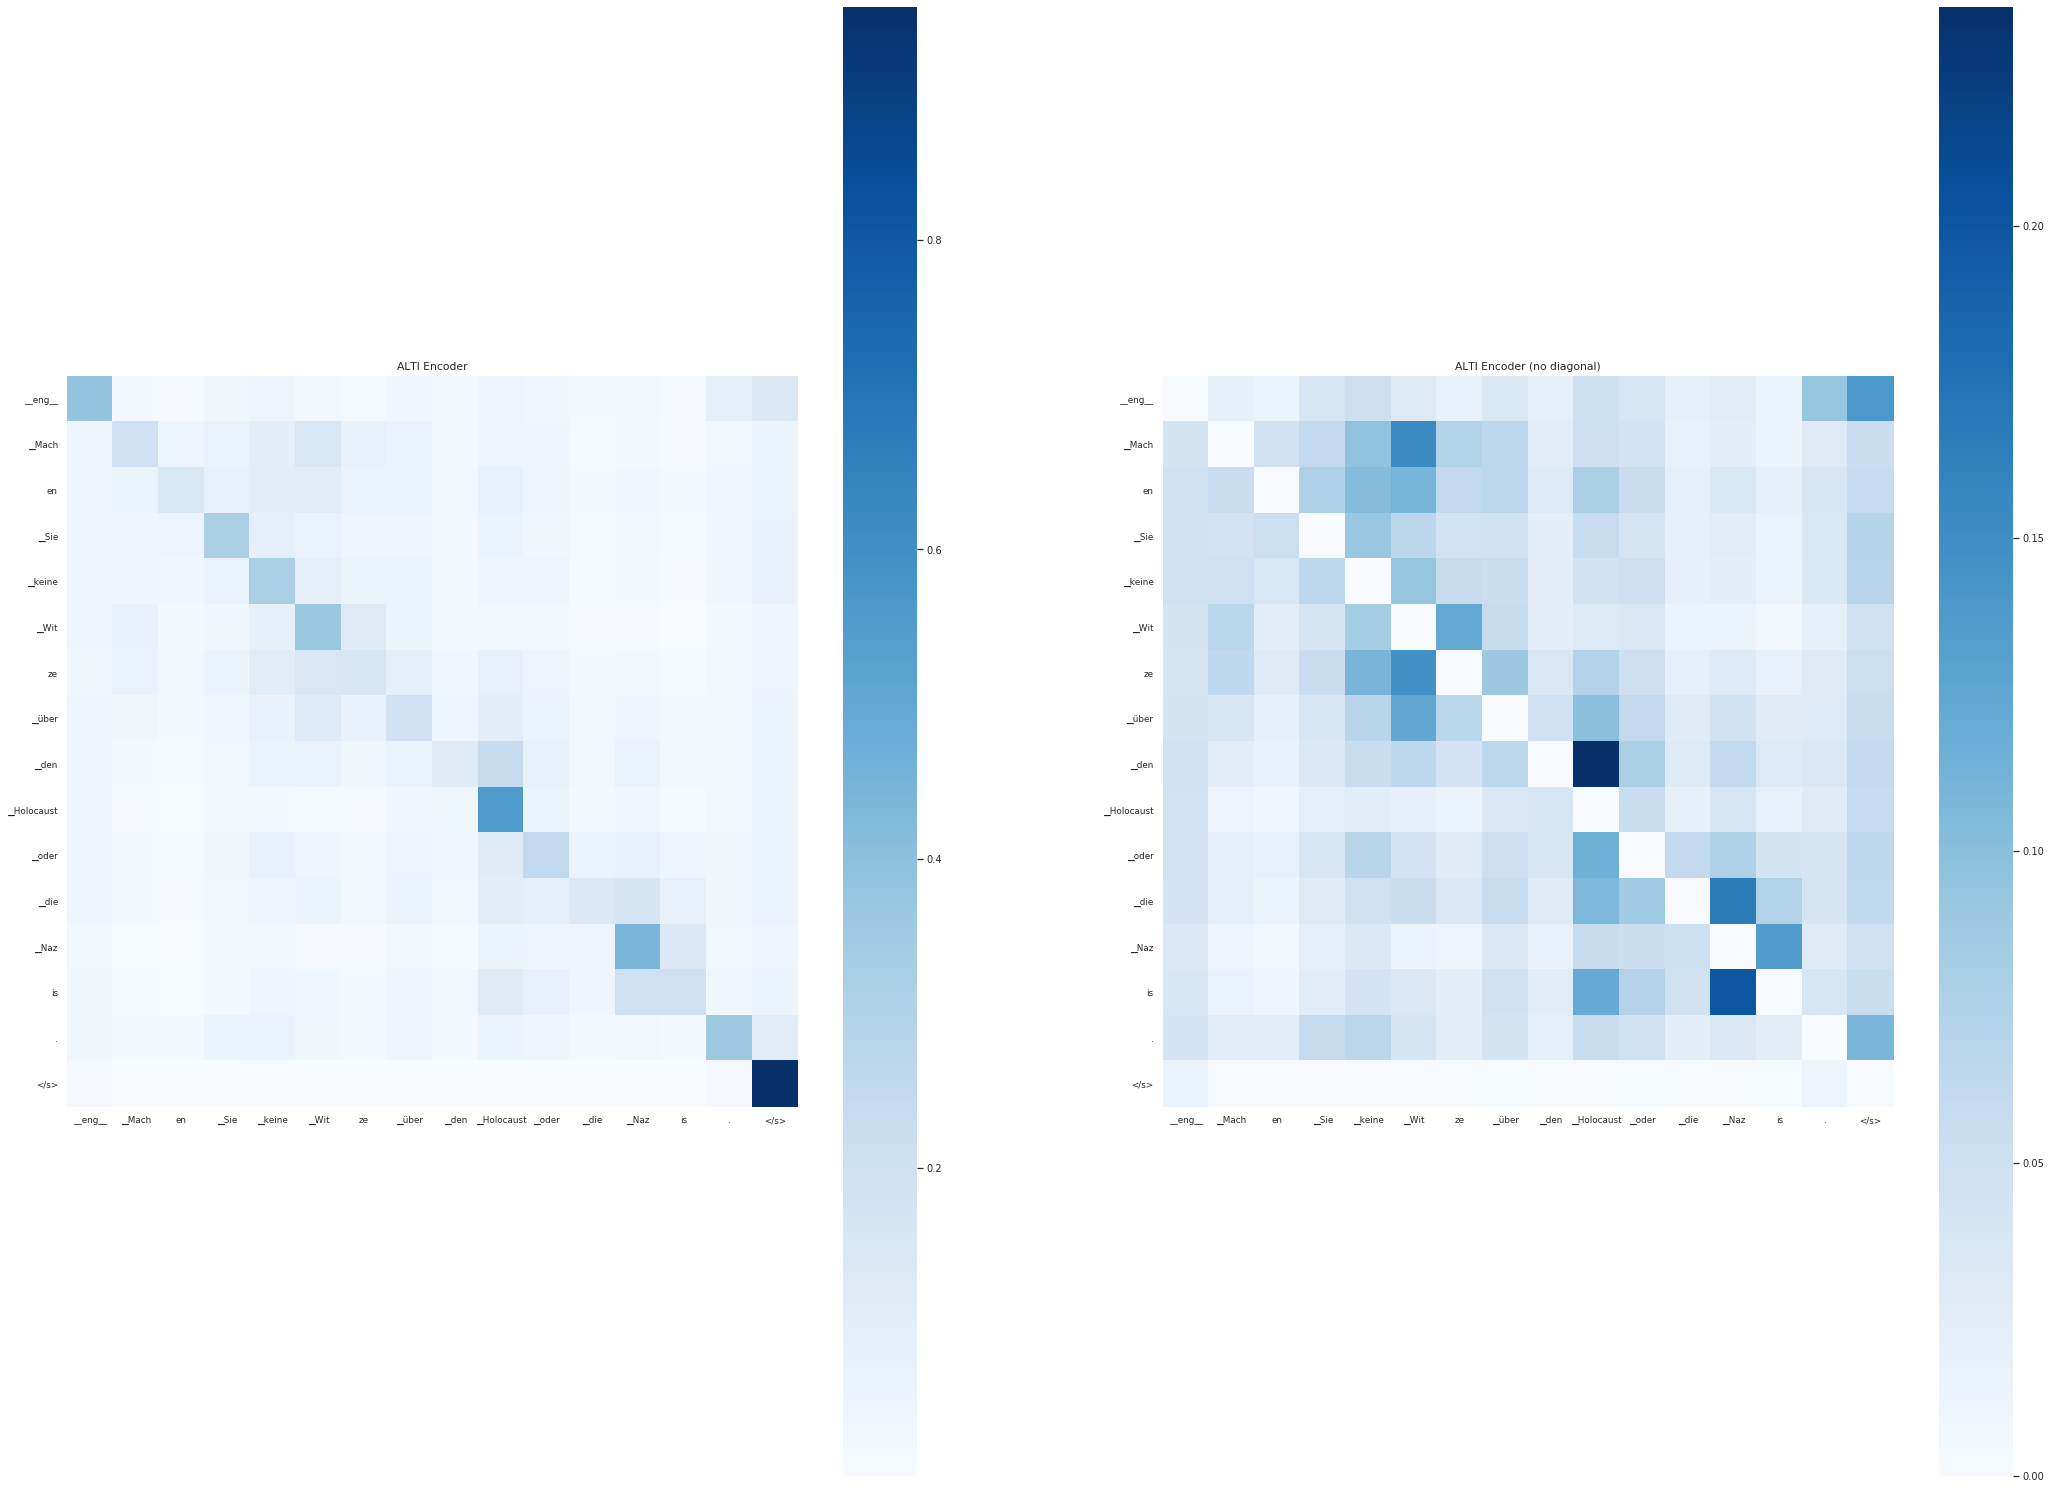

In [264]:
print(src_tensor.size())
print(tgt_tensor.size())
relevances_enc_self_attn = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1',
                                                        norm_mode='min_sum', pre_layer_norm=True)['encoder.self_attn']
                                                        
# Encoder self-attention relevances in last layer (full encoder ALTI)
fig = plt.figure(figsize=(36, 30))
gs = GridSpec(1, 2)
gs.update(wspace=0.2, hspace=0.05)#0.015
ax_left = plt.subplot(gs[0, 0])
ax_right = plt.subplot(gs[0, 1])
relevances_enc_self_attn_last = relevances_enc_self_attn[-1]
relevances_enc_self_attn_last_no_diag = relevances_enc_self_attn_last - torch.diag(relevances_enc_self_attn_last.diag())
df = pd.DataFrame(relevances_enc_self_attn_last.cpu().detach().numpy(),columns= source_sentence, index = source_sentence)
sns.set(font_scale=0.9)
sns.heatmap(df,cmap="Blues",ax=ax_left,square=True)
ax_left.set_title('ALTI Encoder')

df = pd.DataFrame(relevances_enc_self_attn_last_no_diag.cpu().detach().numpy(),columns= source_sentence, index = source_sentence)
sns.heatmap(df,cmap="Blues",ax=ax_right,square=True)
ax_right.set_title('ALTI Encoder (no diagonal)')
plt.gcf().subplots_adjust(bottom=0.2)

### ALTI of the entire model

In [265]:
total_rollout = hub.get_contribution_rollout(src_tensor, tgt_tensor,
                                            'l1', norm_mode='min_sum',
                                            pre_layer_norm=True)['total']

0.083486475
0.1271178
0.18930173
0.24548785
0.2825158
0.31218007
0.35482872
0.38103896
0.4073157
0.43930298
0.46060744
0.4857944
0.50938374
0.5264751
0.54968166
0.5680952
0.58189625
0.5891306
0.5992802
0.6080936


/tmp/ipykernel_3863927/1827802005.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(30, 34)) #20,24


0.6129596


/tmp/ipykernel_3863927/1827802005.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(30, 34)) #20,24


0.6190517


/tmp/ipykernel_3863927/1827802005.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(30, 34)) #20,24


0.62364864


/tmp/ipykernel_3863927/1827802005.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(30, 34)) #20,24


0.6269725


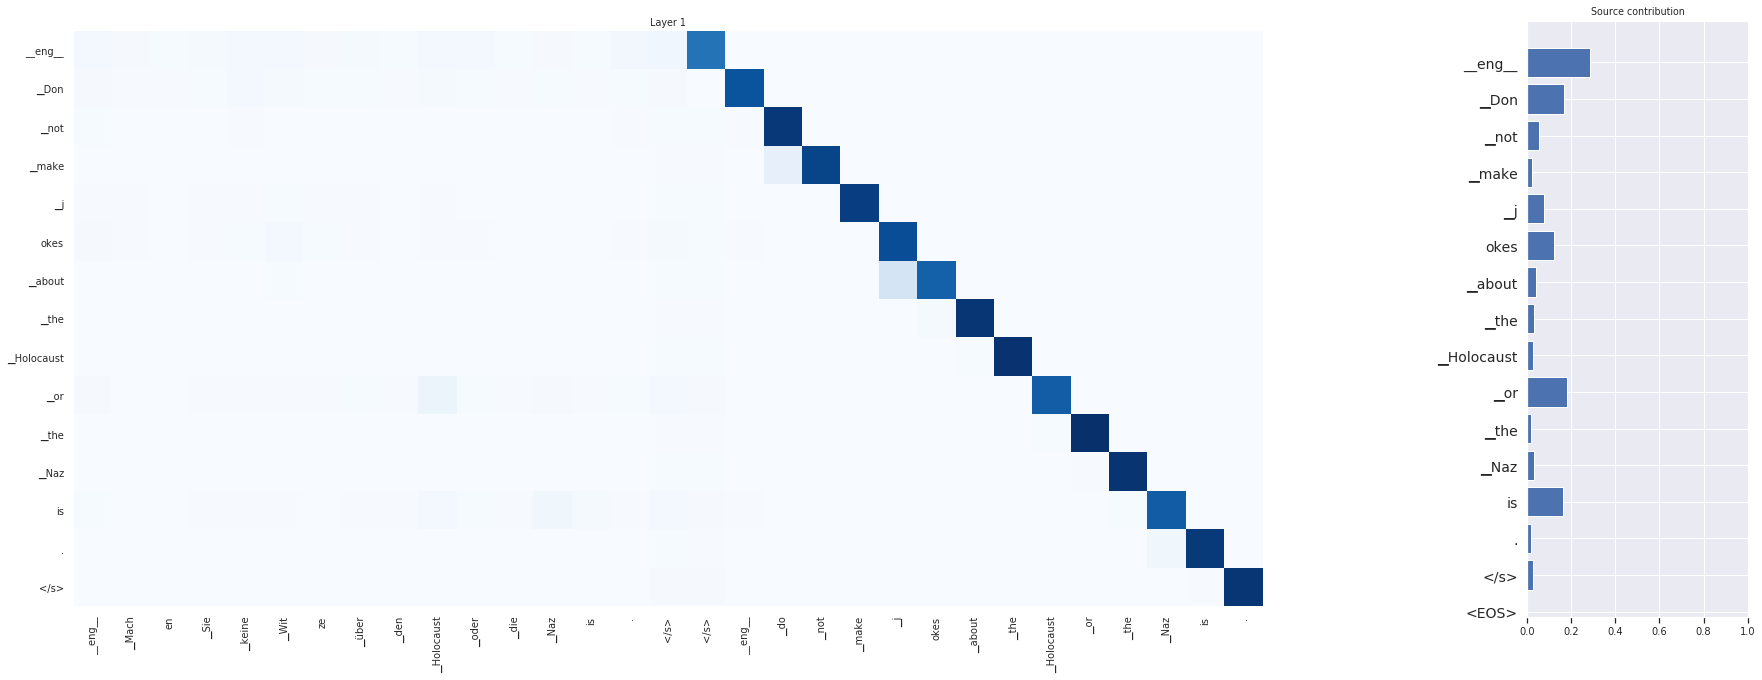

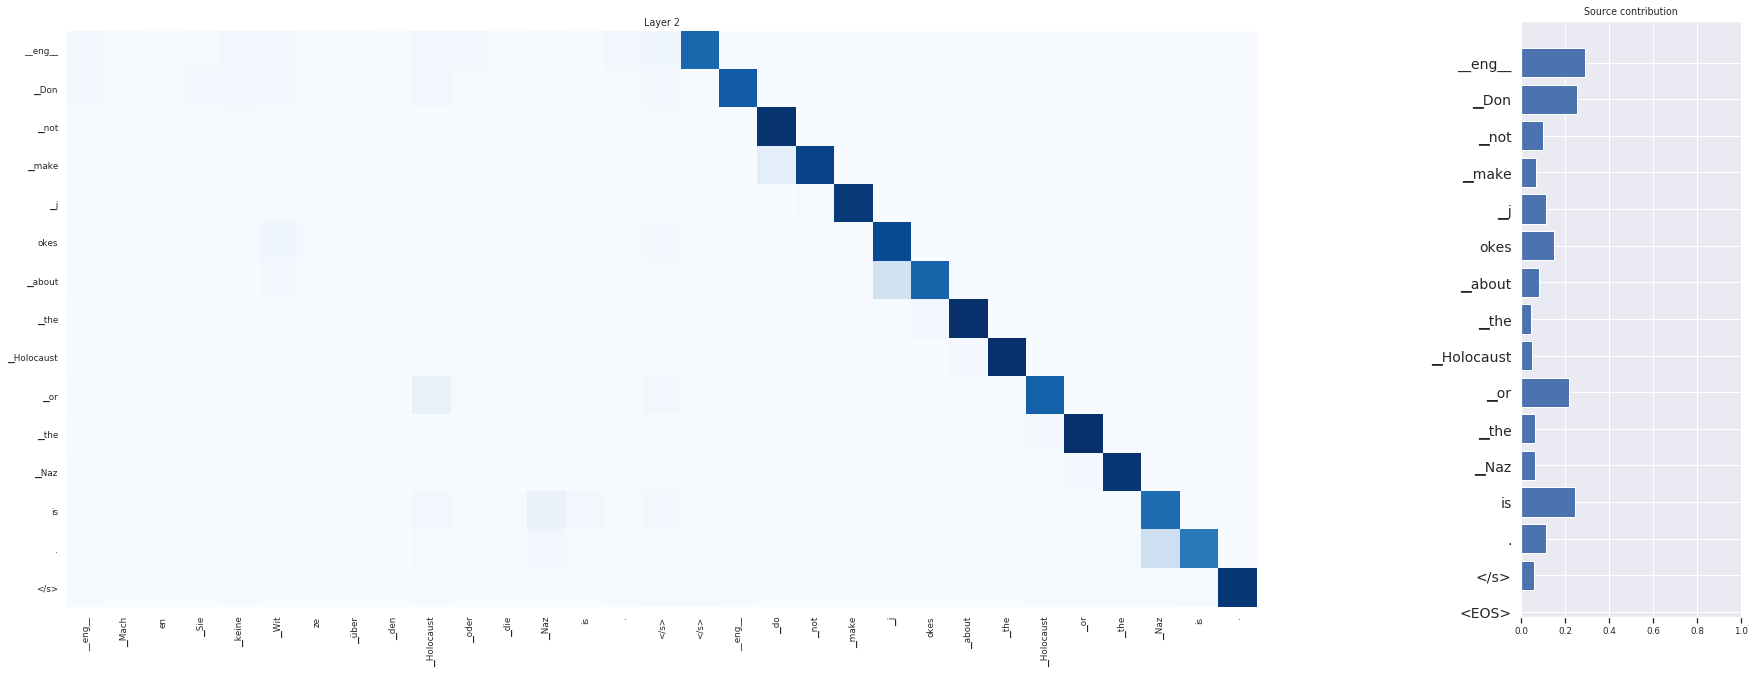

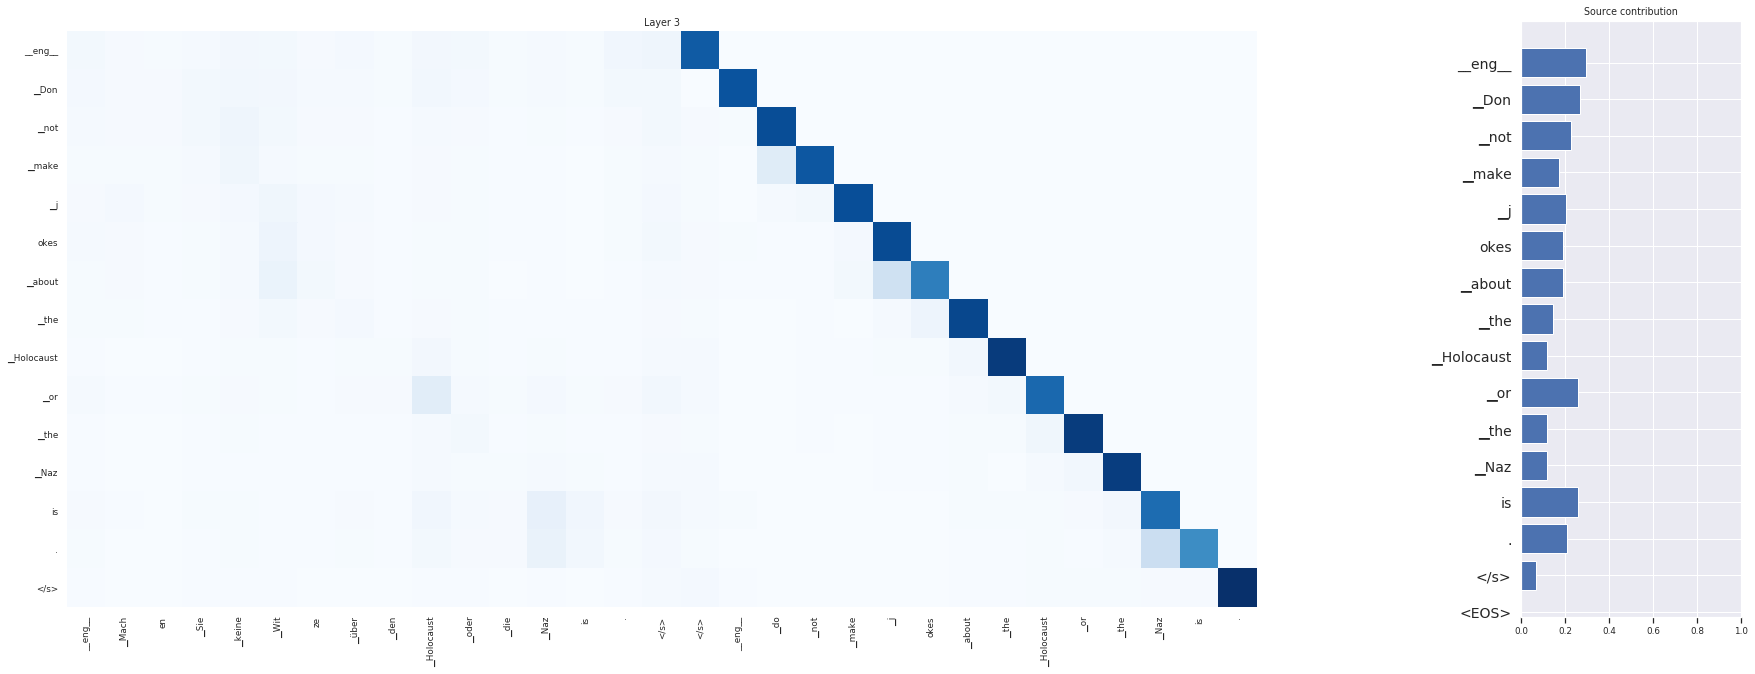

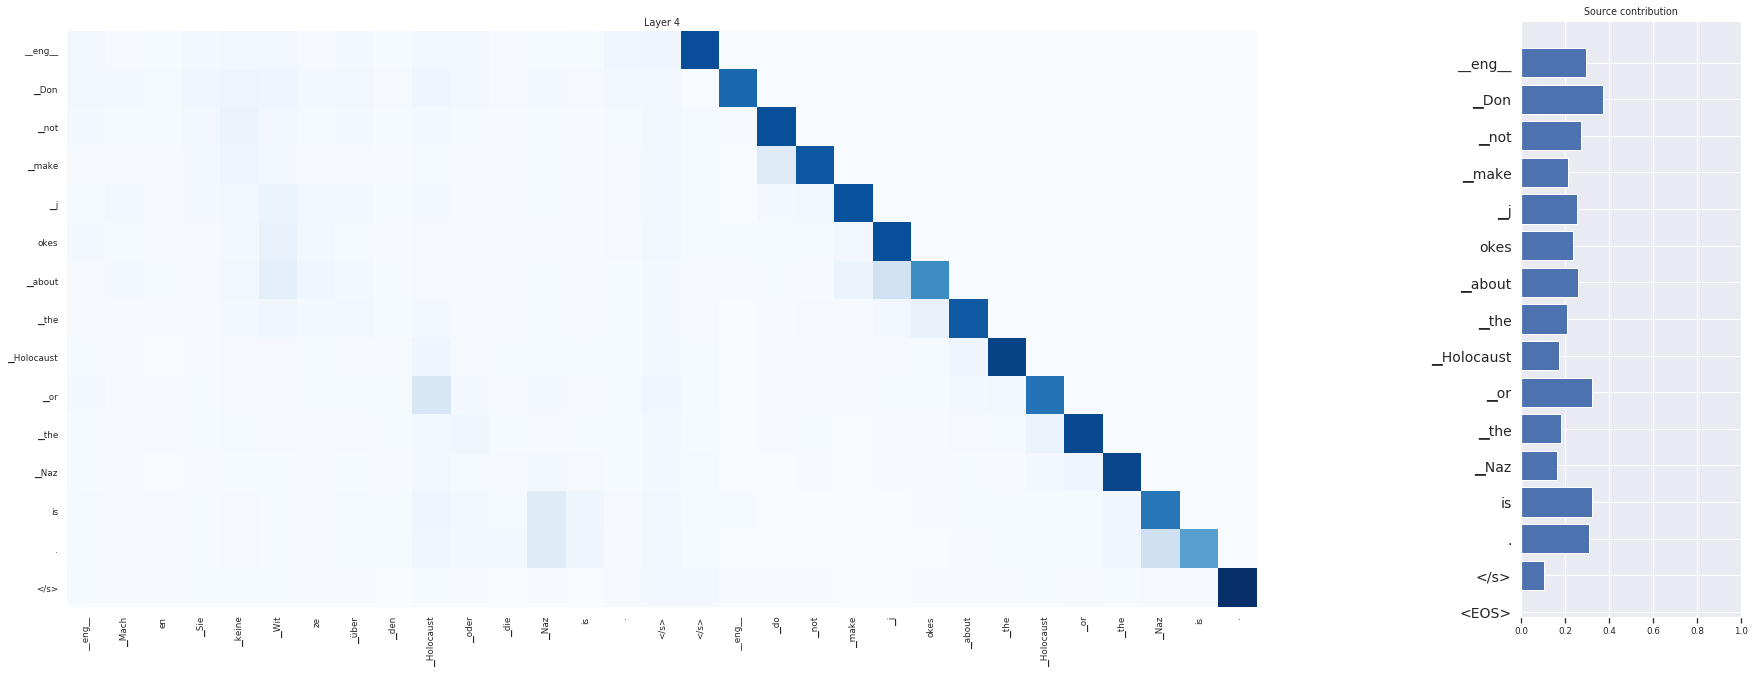

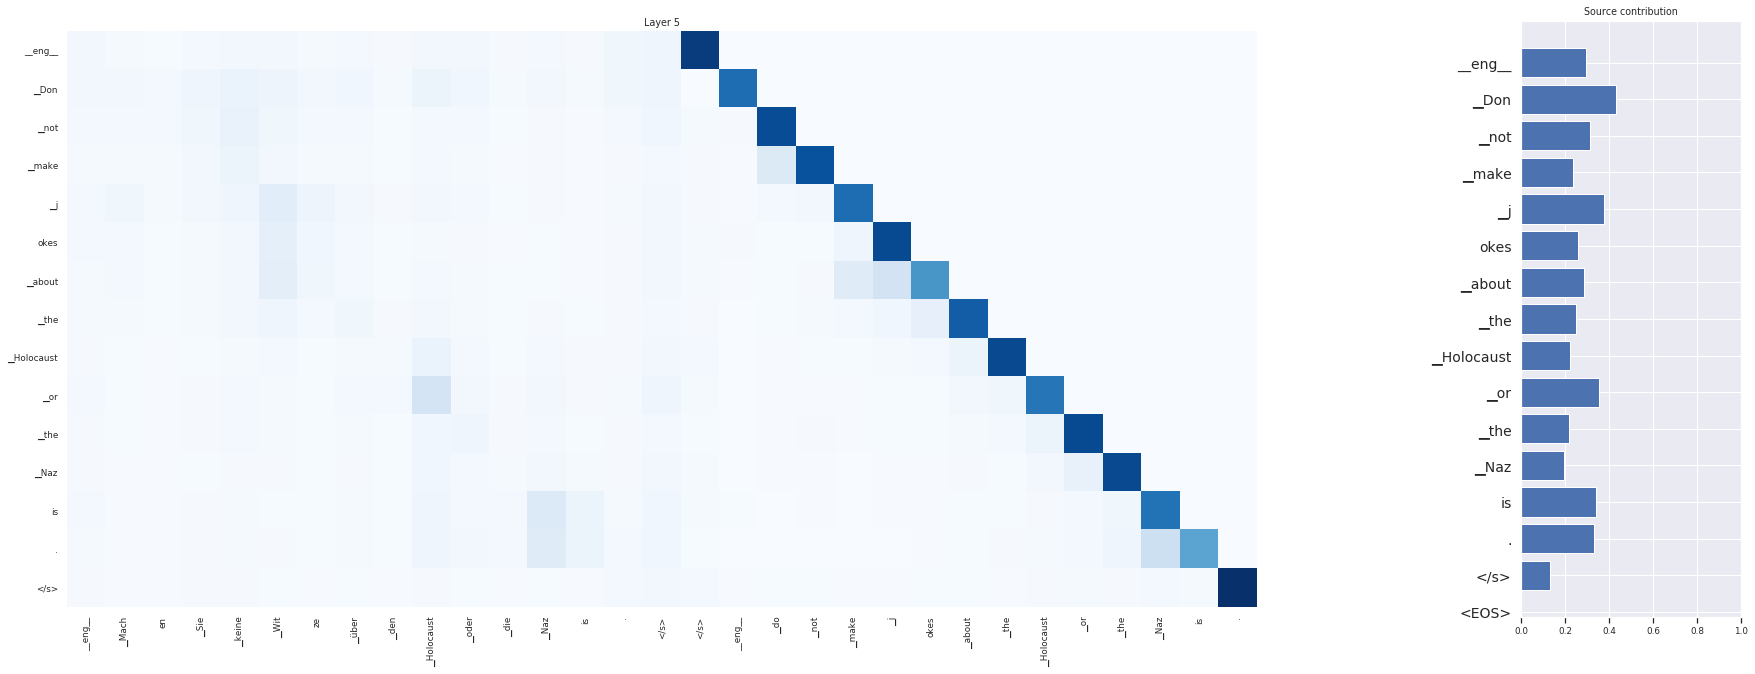

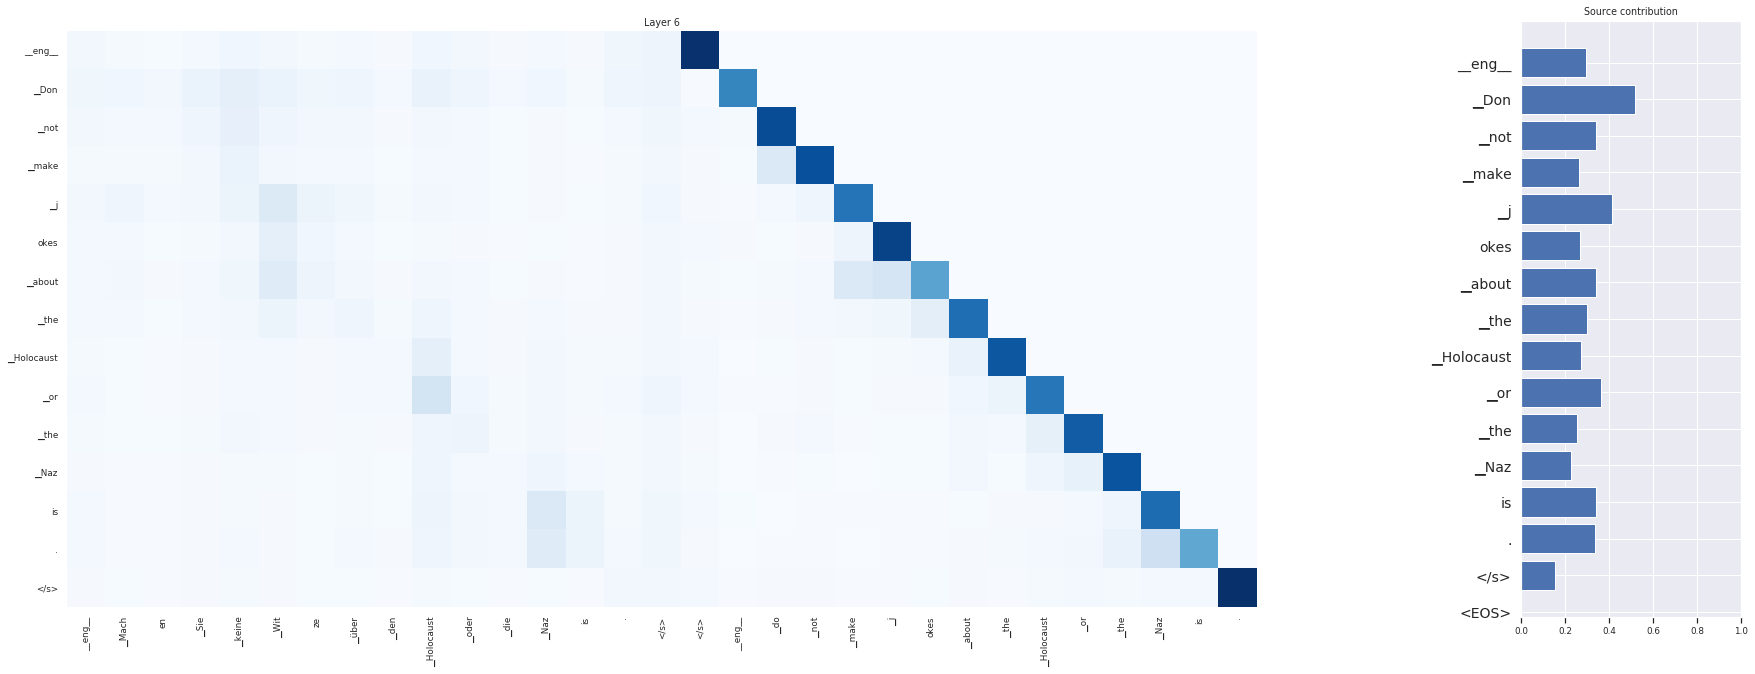

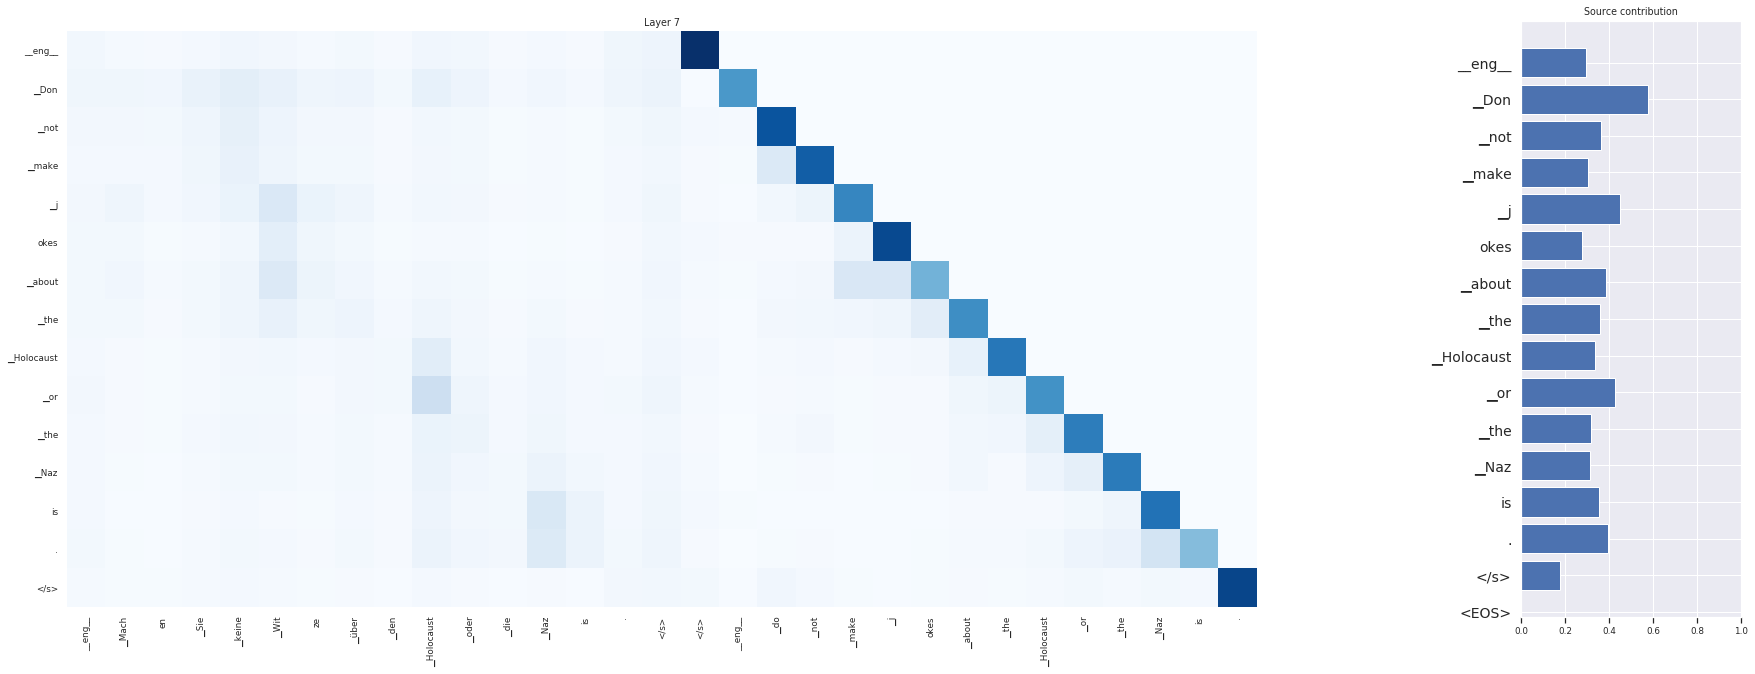

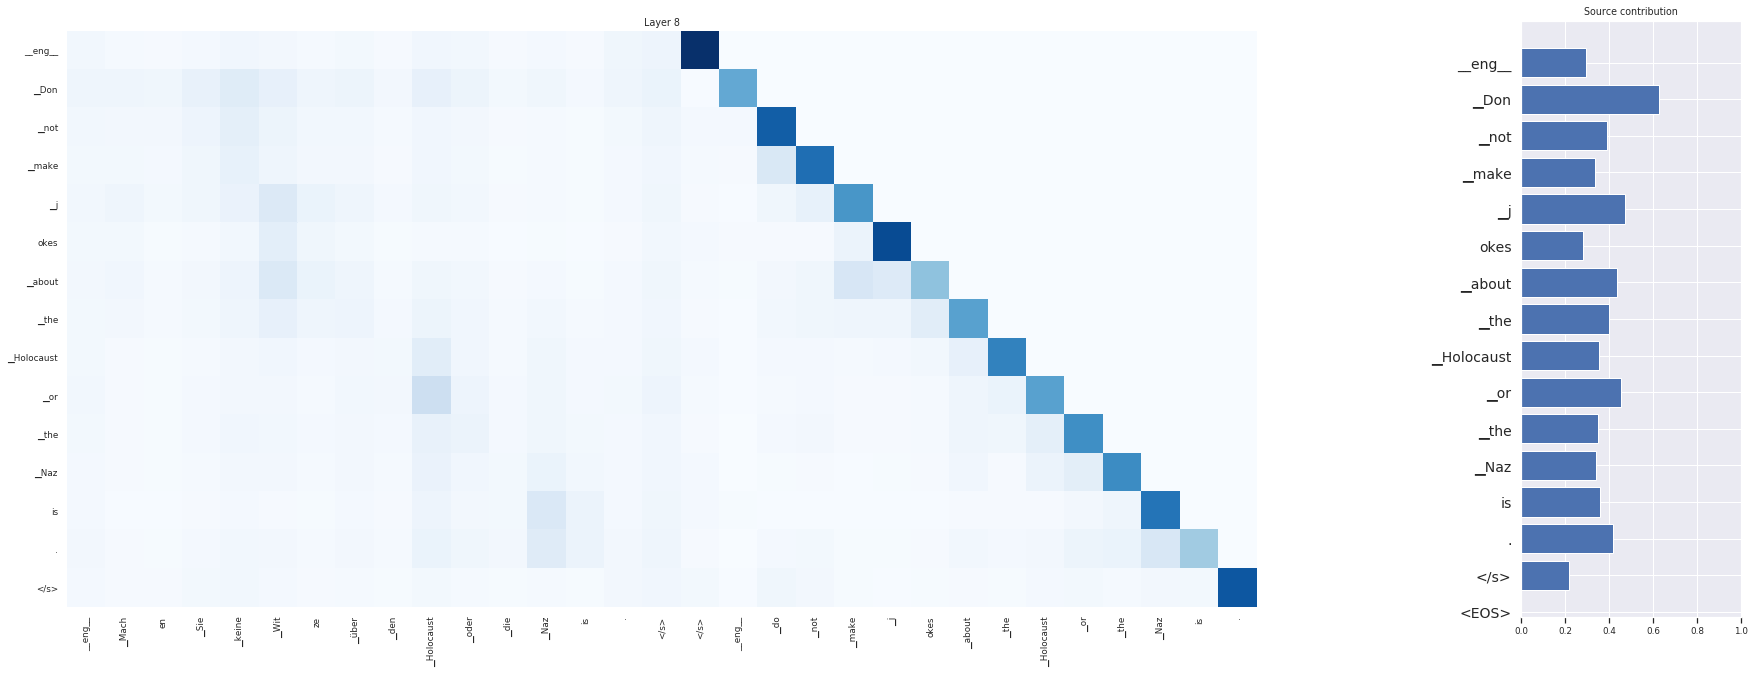

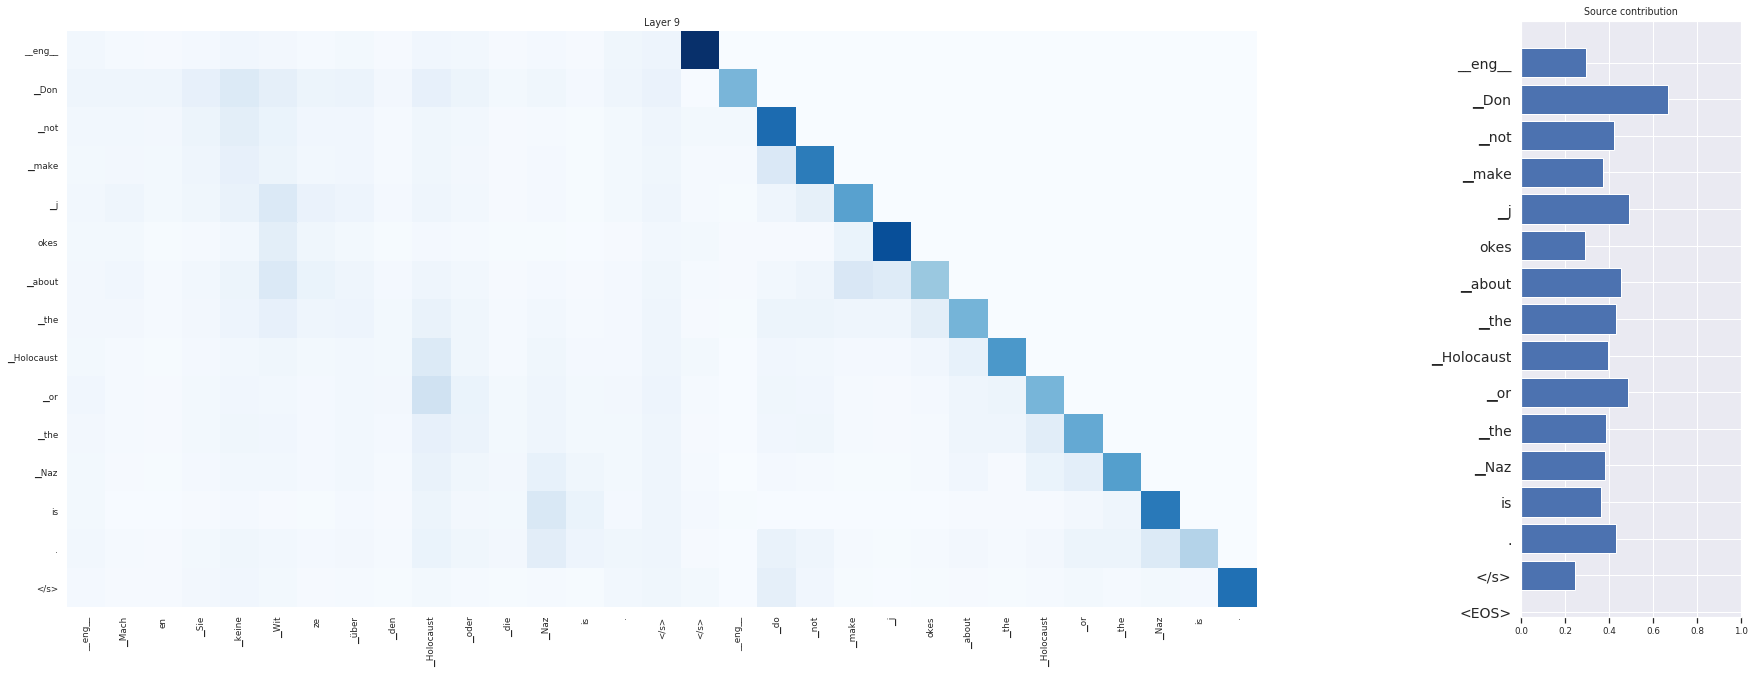

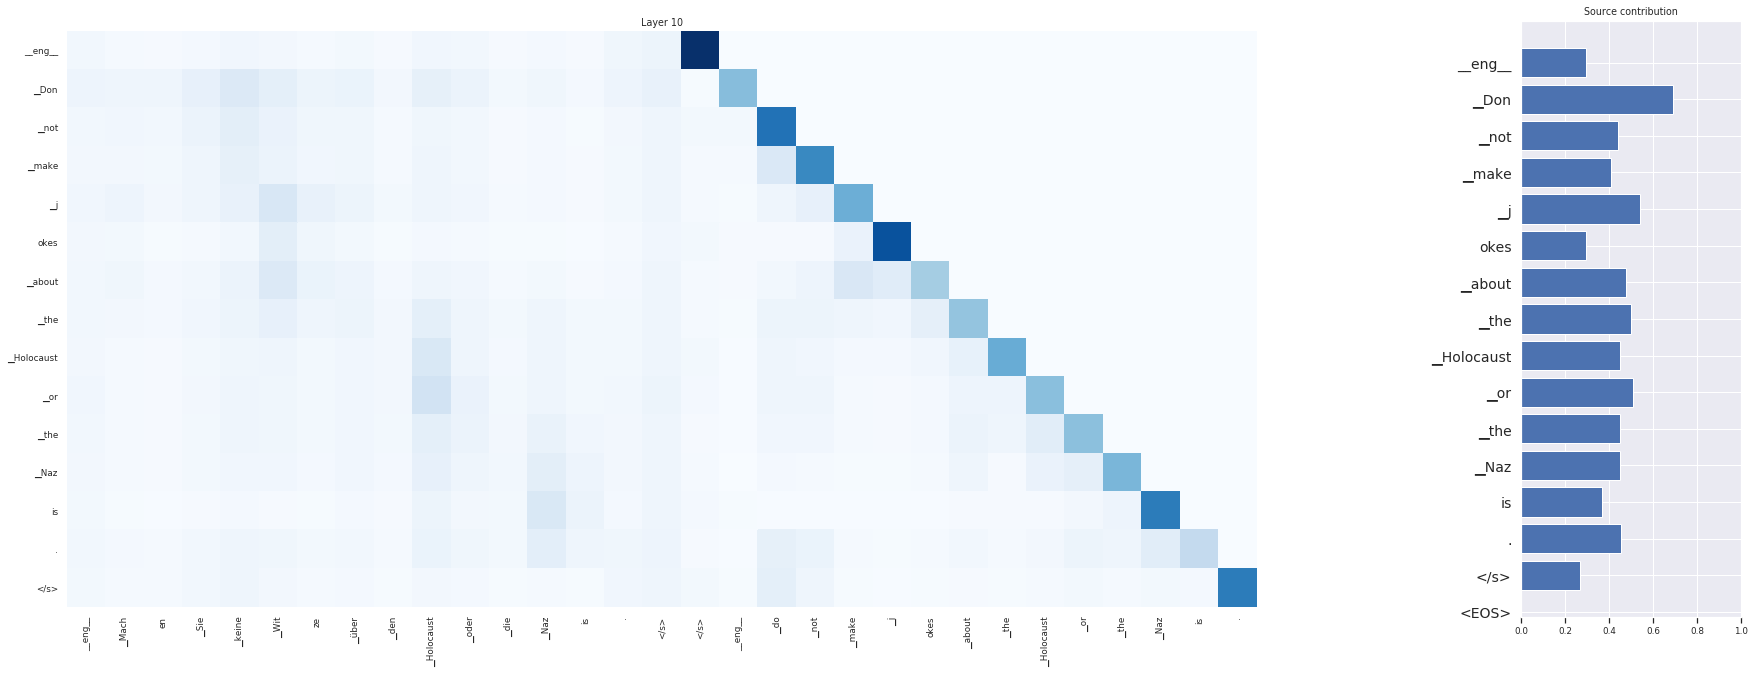

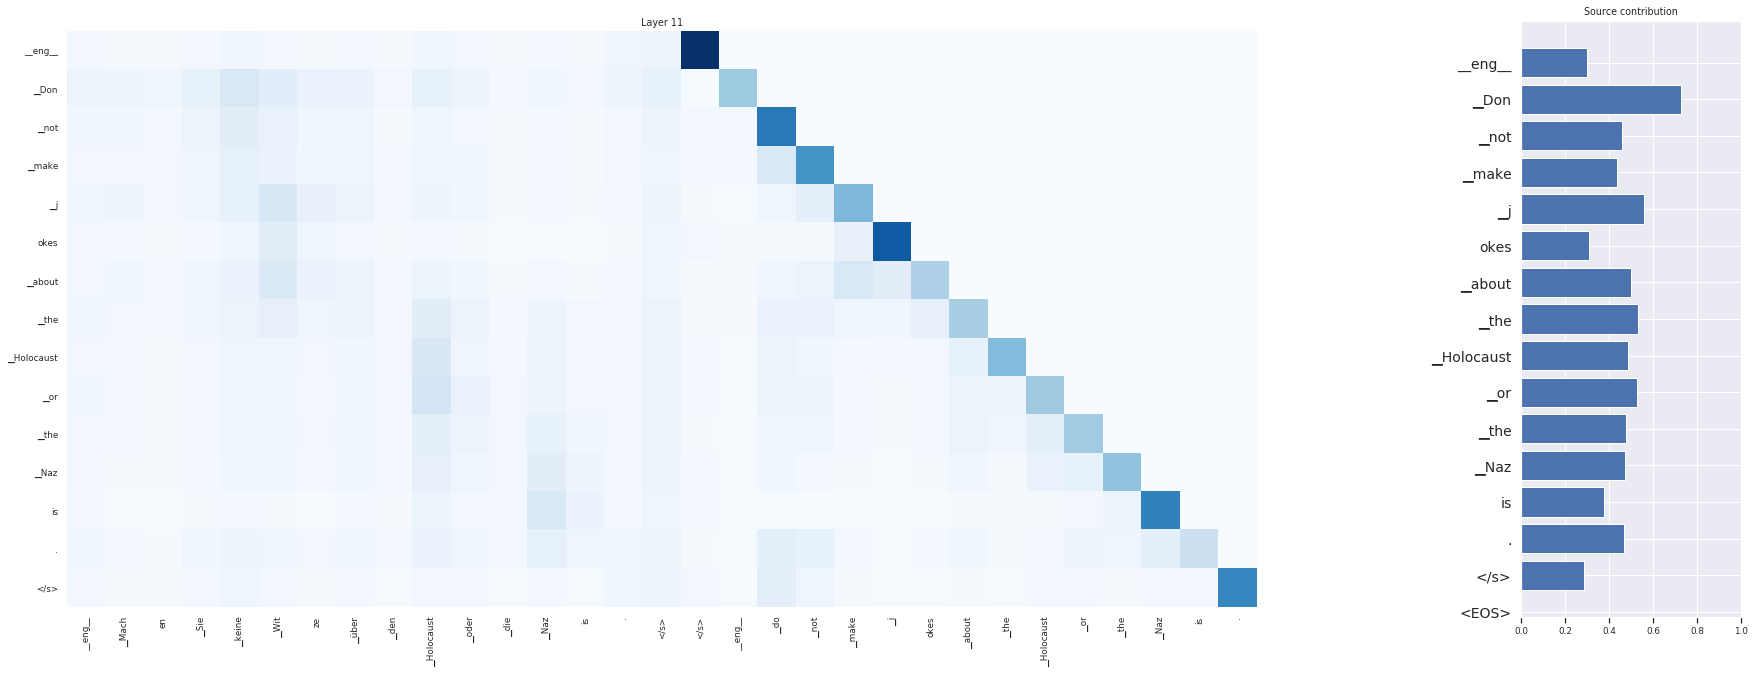

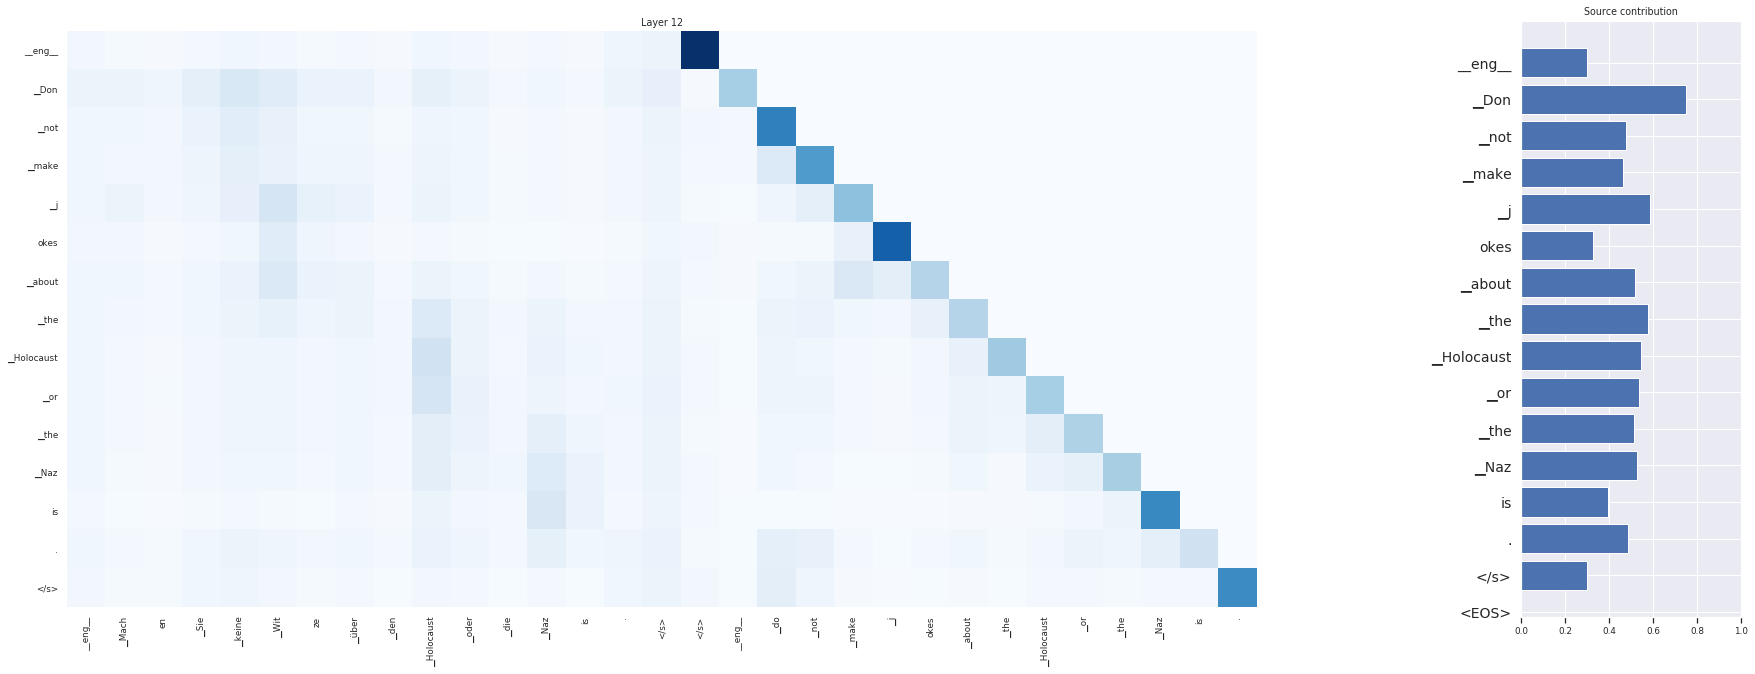

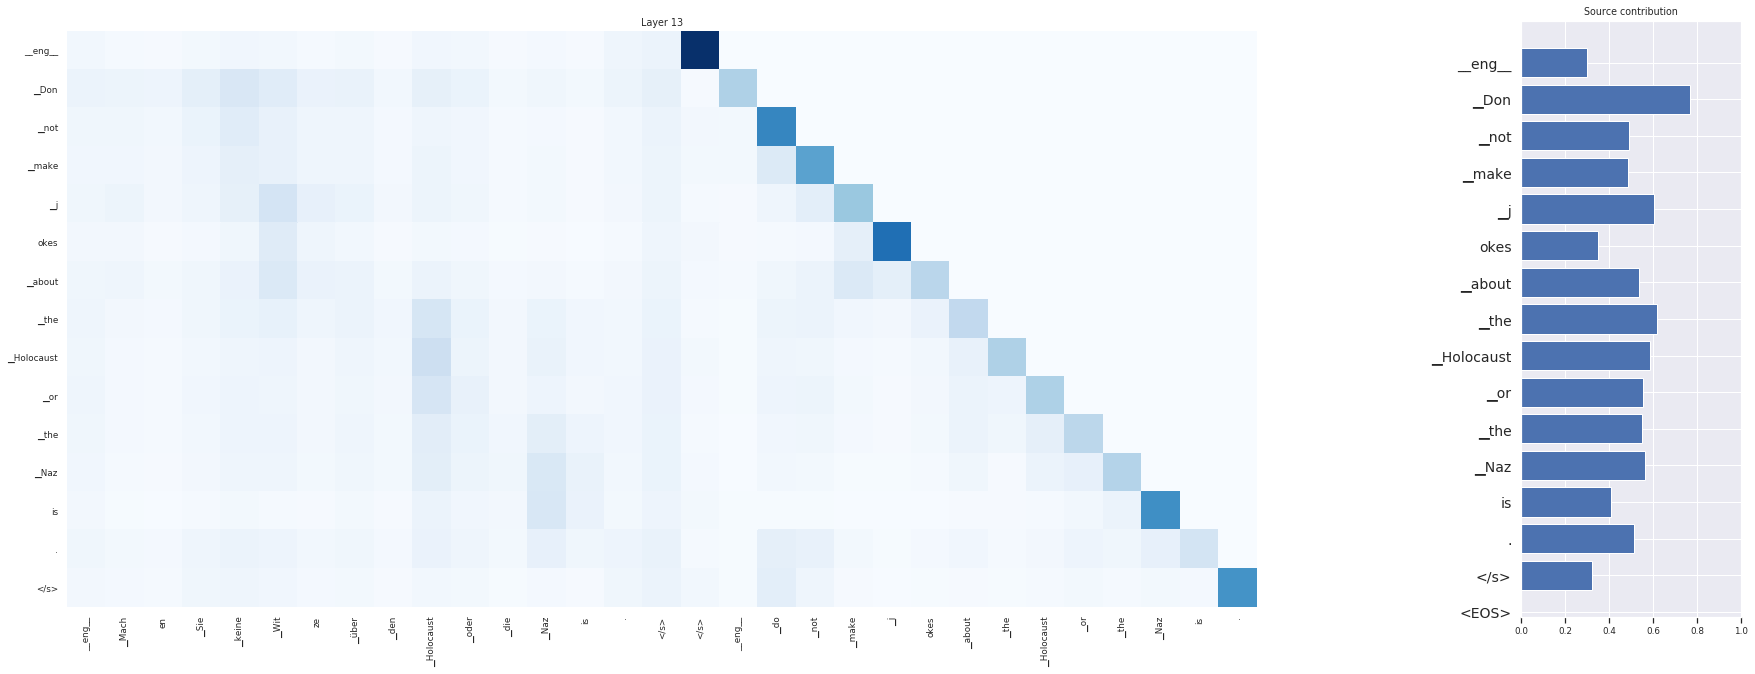

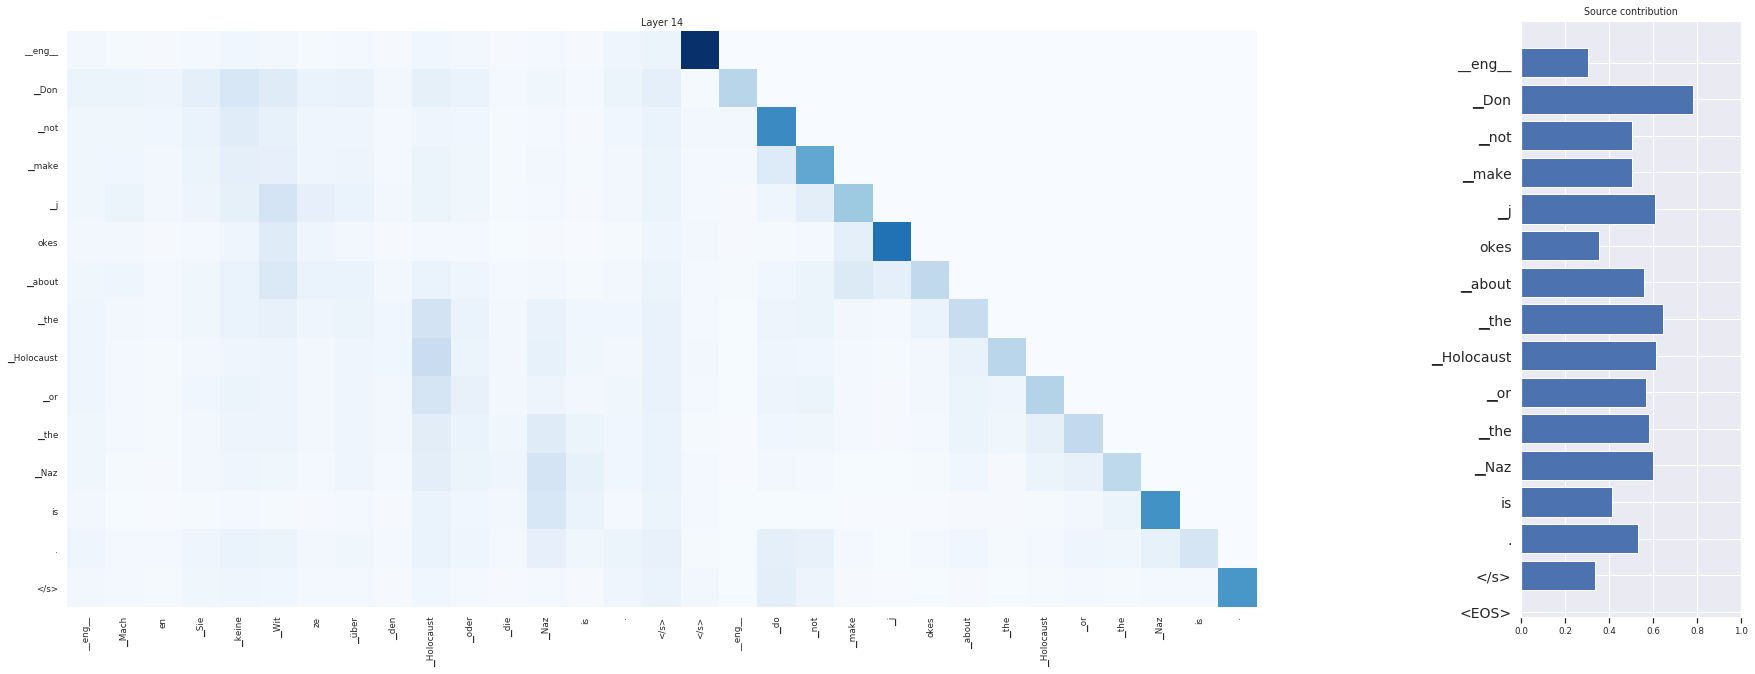

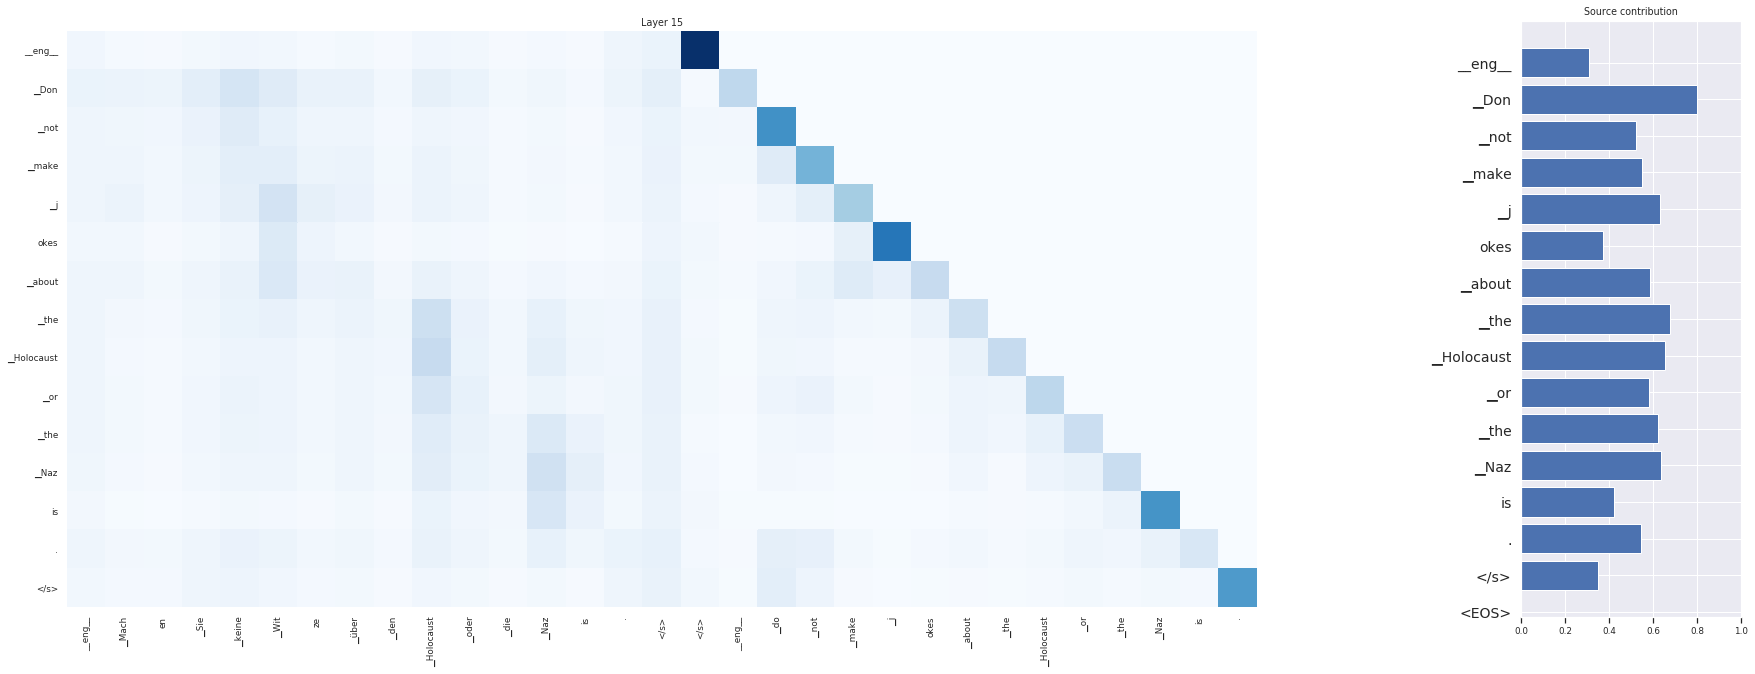

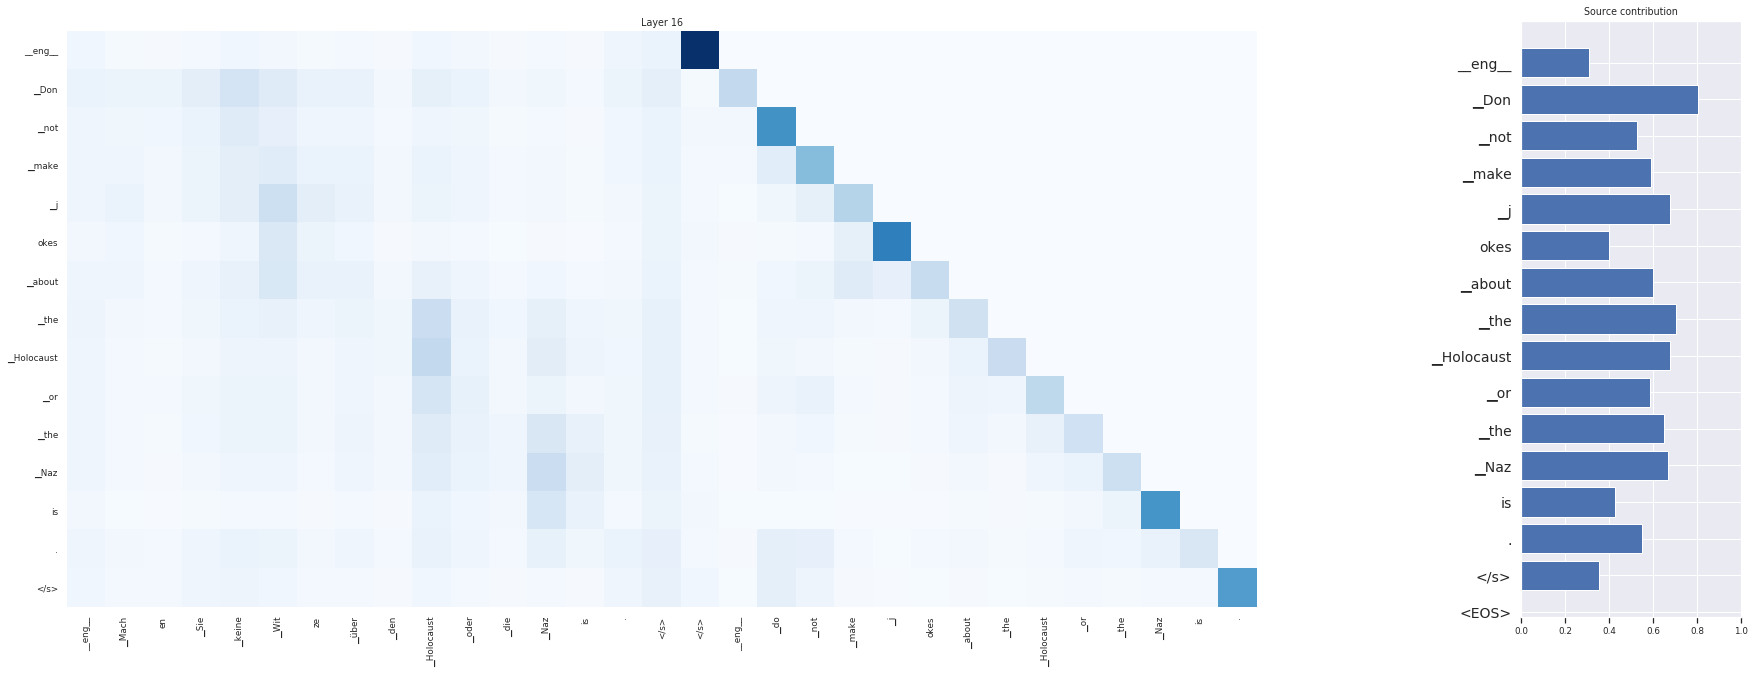

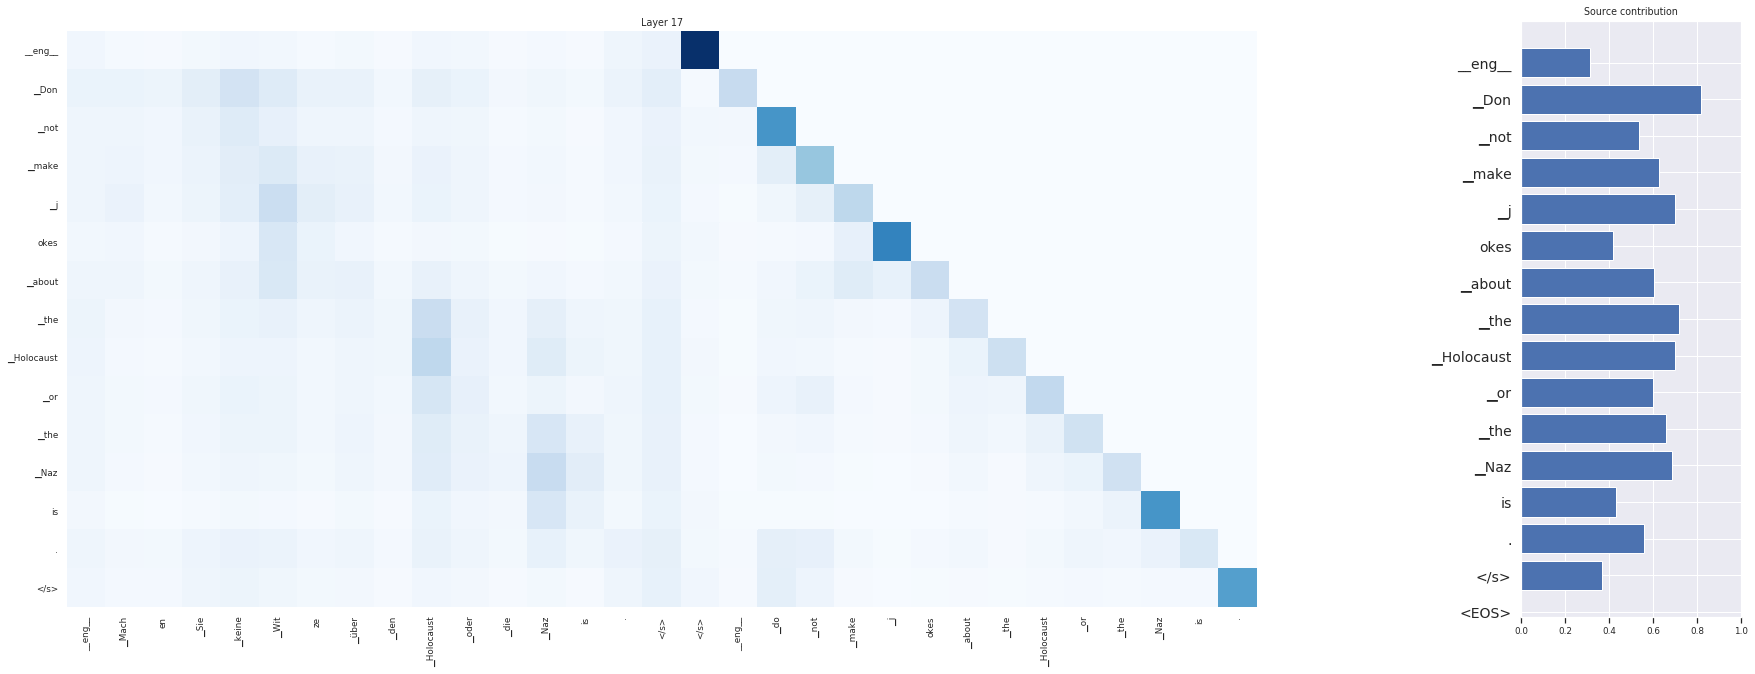

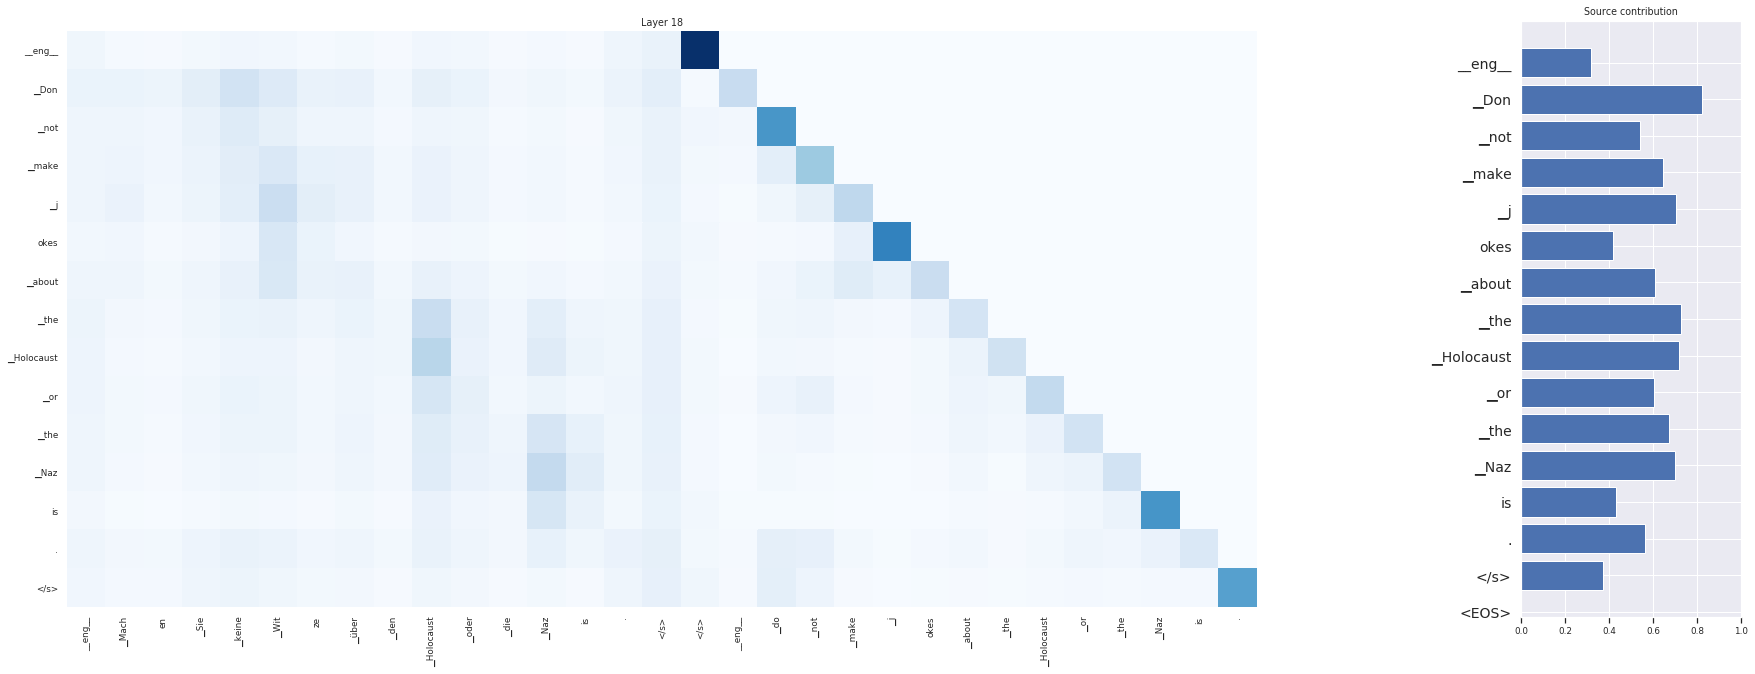

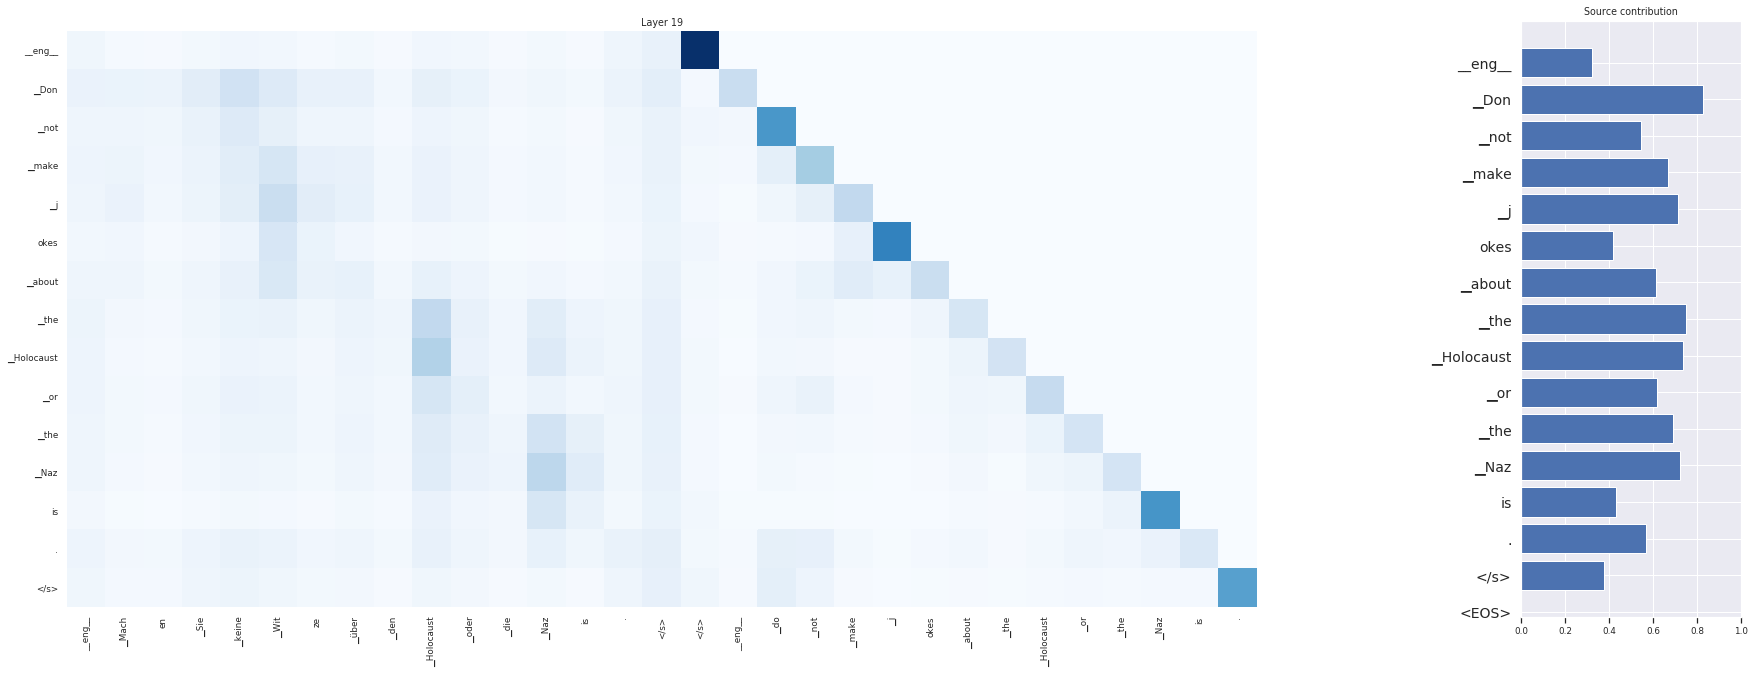

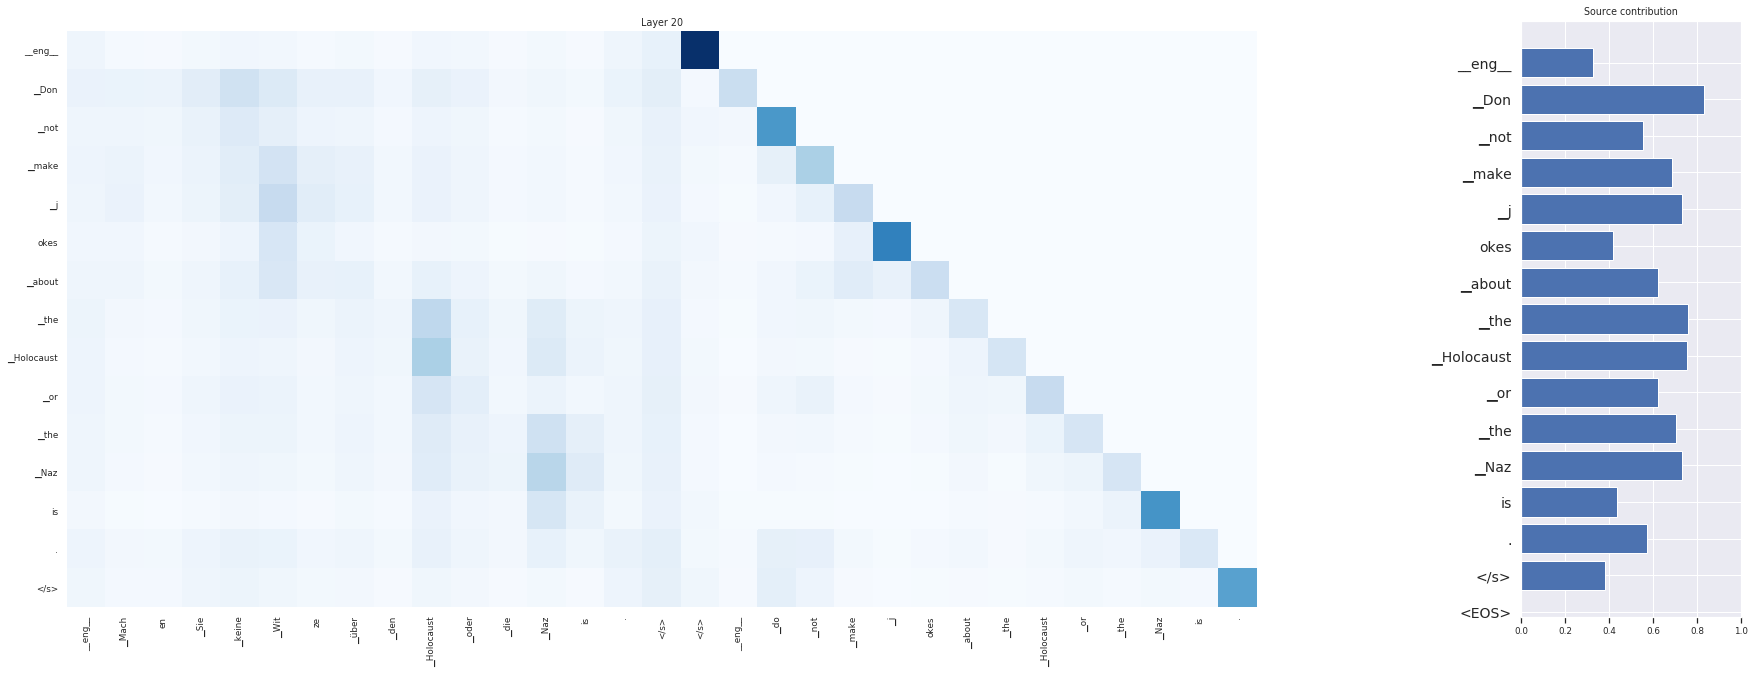

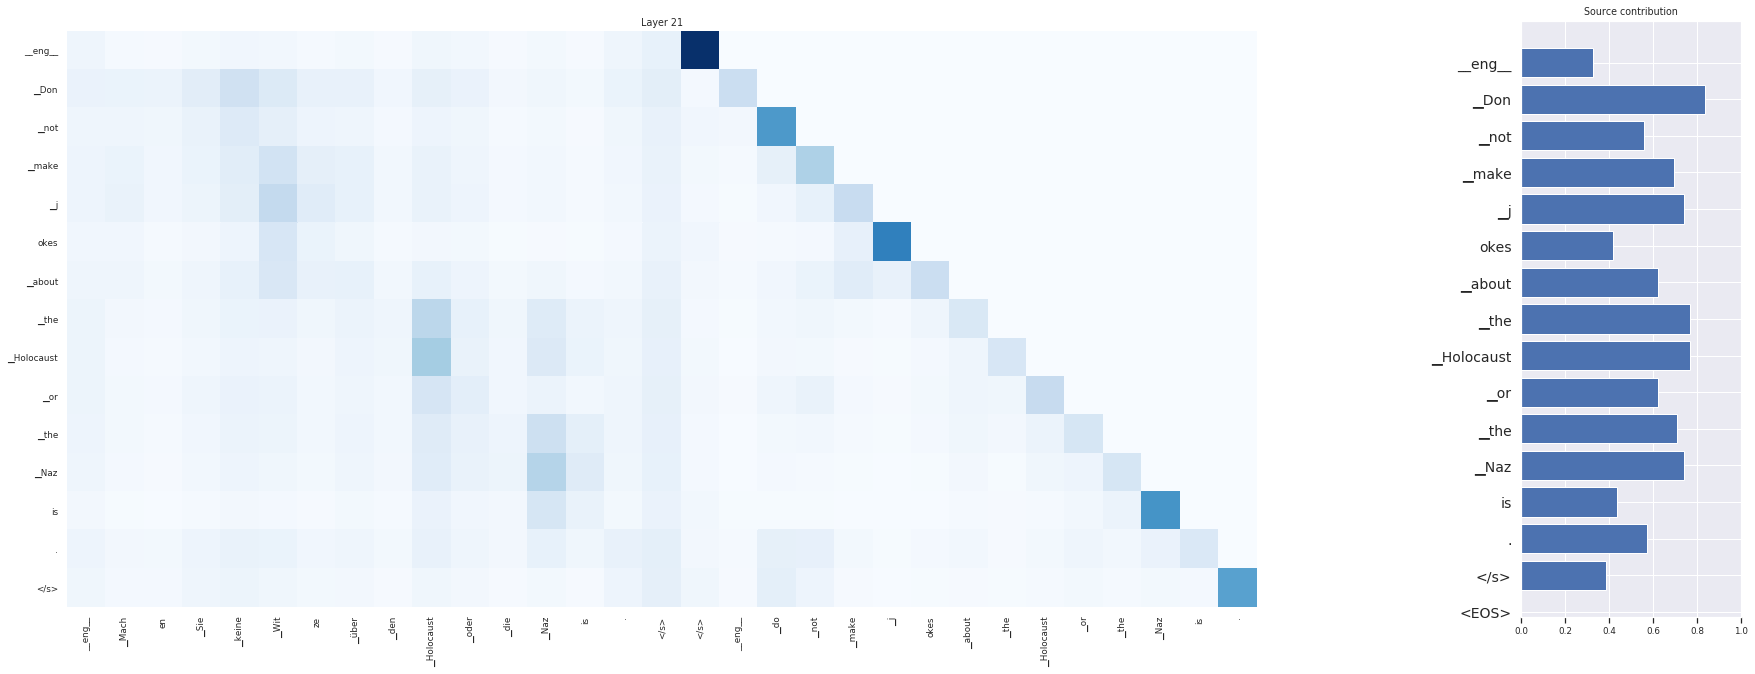

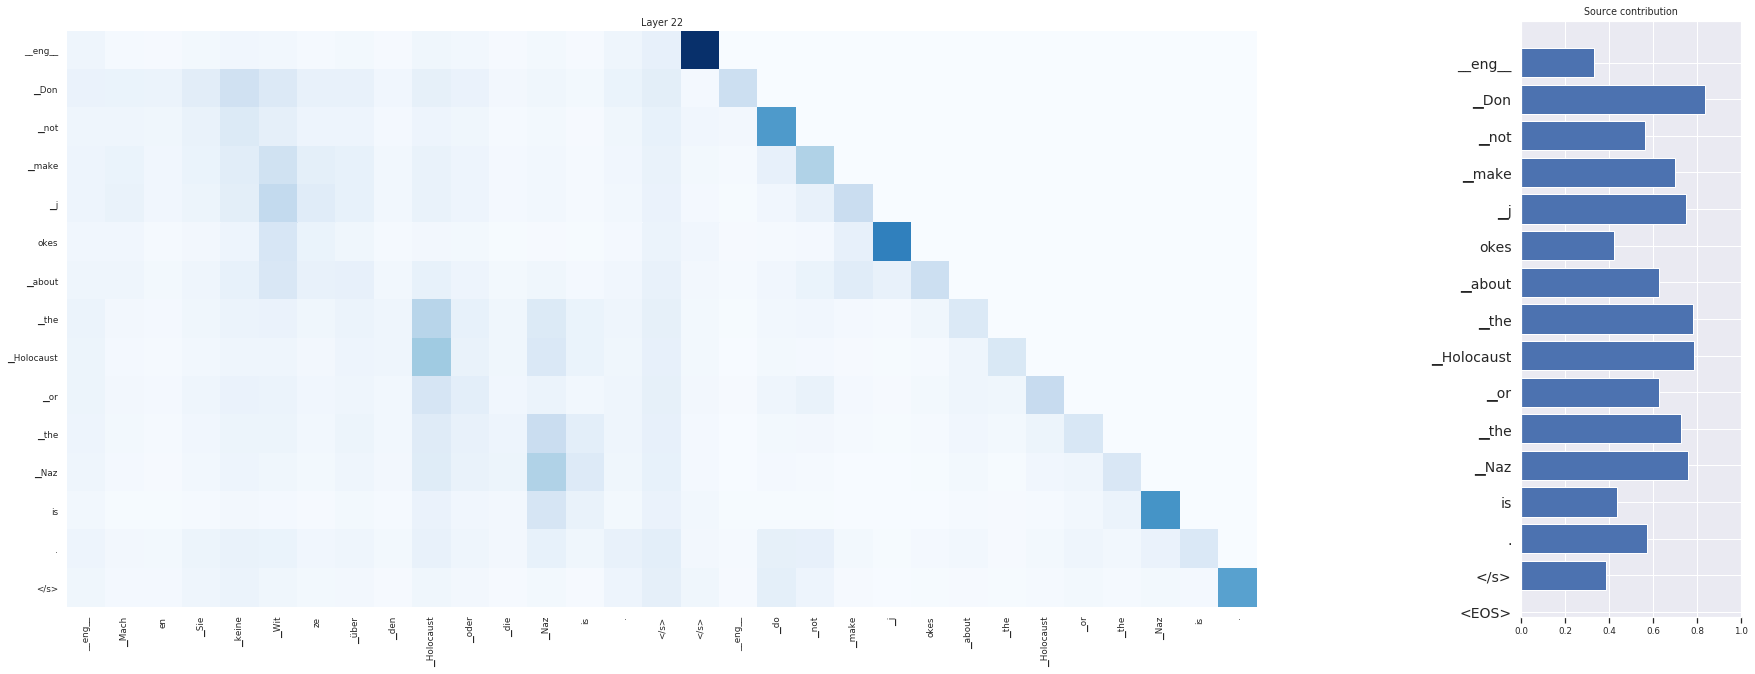

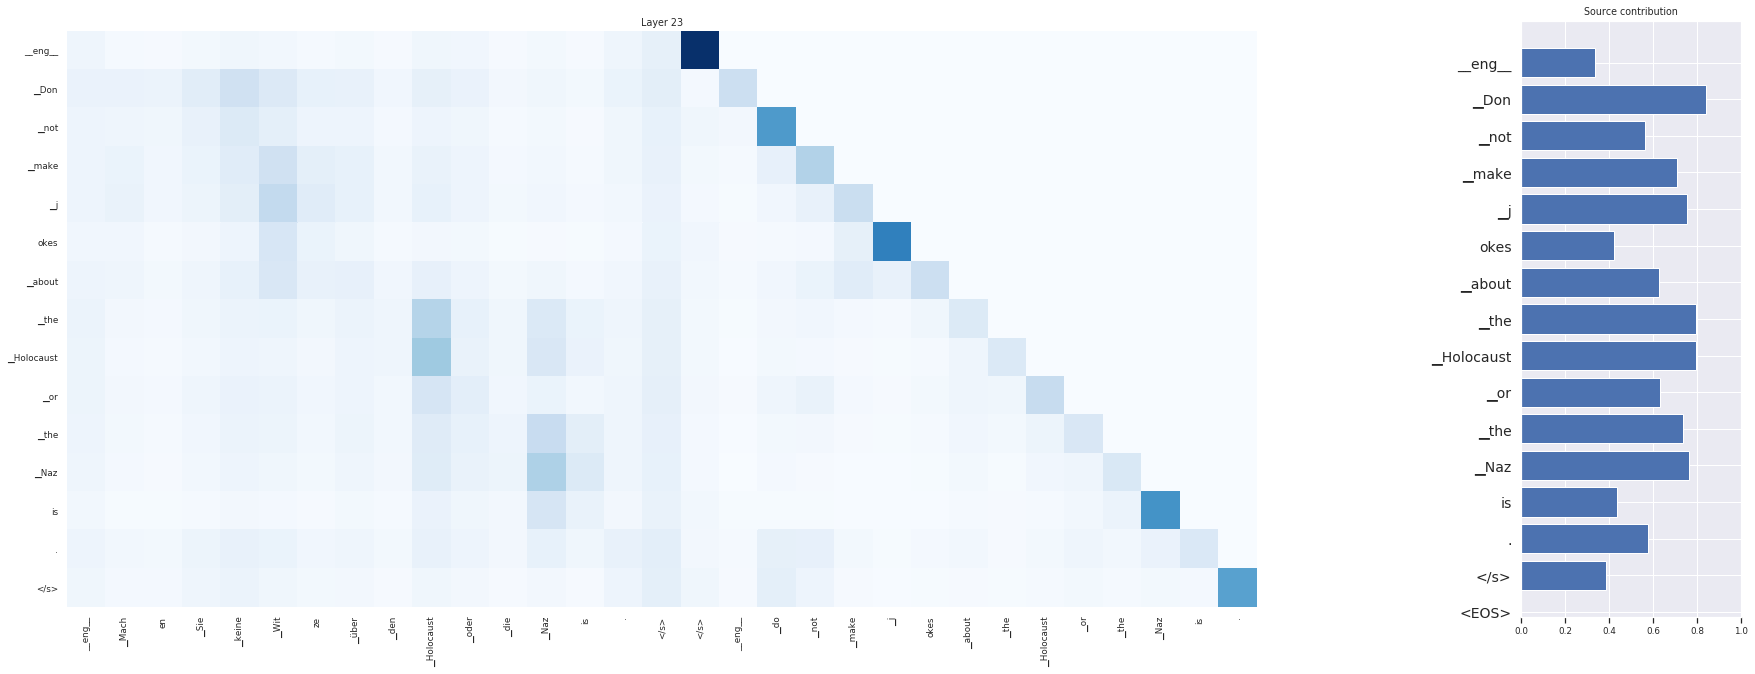

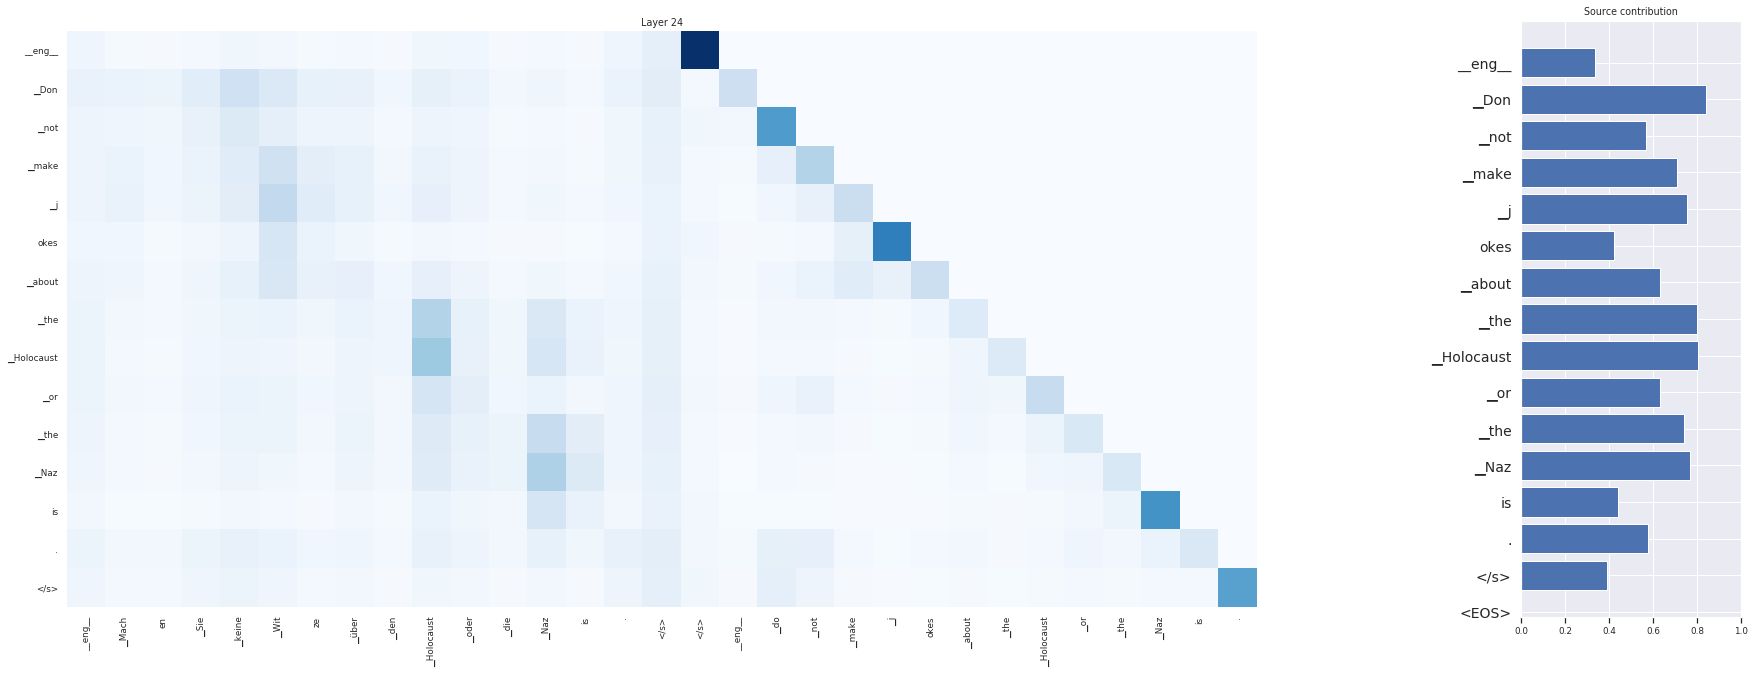

In [266]:
for layer in range(0,NUM_LAYERS):

    fig = plt.figure(figsize=(30, 34)) #20,24
    gs = GridSpec(3, 4)
    gs.update(wspace=1.2, hspace=0.05)#0.015
    ax_main = plt.subplot(gs[0:3, :3])
    ax_yDist = plt.subplot(gs[1, 3])#, sharey=ax_main)
    
    contributions_rollout_layer = total_rollout[layer]
    contributions_rollout_layer_np = contributions_rollout_layer.detach().cpu().numpy()
    df = pd.DataFrame(contributions_rollout_layer_np, columns = source_sentence + target_sentence, index = predicted_sentence)
    sns.set(font_scale=0.8) #font size text
    sns.heatmap(df,cmap="Blues",square=True,ax=ax_main,cbar=False)#Reds,center=0
    src_contribution = contributions_rollout_layer_np[:,:len(src_tok)].sum(-1) #src contribution for target token, 
    src_contribution_mean= np.mean (src_contribution)
    trg_contribution_mean= 1-src_contribution
    print (src_contribution_mean)

    df_src_contribution = pd.DataFrame(src_contribution, columns = ['src_contribution'], index = pred_tok)
    #sns.set_style("white")
    ax_yDist.barh(range(0,len(pred_tok)), df_src_contribution.src_contribution, align='center')
    plt.yticks(ticks = range(0,len(tgt_tok + ['<EOS>'])) ,labels = pred_tok + ['<EOS>'],fontsize='14')
    plt.gca().invert_yaxis()
    plt.grid(visible=True)
    ax_yDist.set_xlim(0,1)

    ax_main.set_title('Layer ' + str(layer+1))
    ax_yDist.set_title('Source contribution')
    
    #sns.despine(left=True, bottom=True)
    ax_yDist.xaxis.set_ticks_position("bottom")
    # ax_yDist.xaxis.grid(False)
    # ax_yDist.yaxis.grid(False)
    #plt.gcf().subplots_adjust(bottom=0.2)

In [272]:
len_source = len(src_tok)
palabra_fila = 11 # fila donde está ass
layer = -1
print (total_rollout[layer,palabra_fila,:len_source])
total_source_palabra = total_rollout[layer,palabra_fila,:len_source].sum()
print('total_source_palabra', total_source_palabra)

tensor([0.0322, 0.0134, 0.0098, 0.0228, 0.0344, 0.0273, 0.0180, 0.0338, 0.0195,
        0.0801, 0.0488, 0.0388, 0.2167, 0.0891, 0.0288, 0.0532],
       grad_fn=<SliceBackward0>)
total_source_palabra tensor(0.7668, grad_fn=<SumBackward0>)


In [273]:
import matplotlib
color_name = 'color{}'
define_color = '\definecolor{{{}}}{{HTML}}{{{}}}'
box = '\mybox{{{}}}{{\strut{{{}}}}}'

def normalize_attribution_visualization(attributions):
    """Applies min-max normalization for visualization purposes."""
    min_importance_matrix = attributions.min(0, keepdim=True)[0]
    max_importance_matrix = attributions.max(0, keepdim=True)[0]
    attributions = (attributions - min_importance_matrix) / (max_importance_matrix - min_importance_matrix)
    return attributions
def latex_colorize(text, weights):
    """https://github.com/ucinlp/facade/blob/facade/util/generate_colorize.py"""

    s = ''
    for w, x in zip(text, weights):
        w = w.replace('#','\#')
        w = w.replace('_','$\_$')
        w = w.replace('▁','$\_$')
        w = w.replace('<','$<$')
        w = w.replace('>','$>$')
        color = np.digitize(x, np.arange(0, 0.3, 0.003)) - 1 # 0.01 indica la granularidad de los colores
        s += ' ' + box.format(color_name.format(color), w)
    return s

def prepare_colorize():
    """ Define scale of colors for macros.tex."""

    with open('./colorize.tex', 'w') as f:
        cmap = plt.cm.get_cmap('Blues') # escoger color
        for i, x in enumerate(np.arange(0, 0.3, 0.003)): # 0.01 indica la granularidad de los colores
            rgb = matplotlib.colors.rgb2hex(cmap(x)[:3])
            # convert to upper to circumvent xcolor bug
            rgb = rgb[1:].upper() if x > 0 else 'FFFFFF'
            f.write(define_color.format(color_name.format(i), rgb))
            f.write('\n')
        #f.write('''\\newcommand*{\mybox}[2]{\\tikz[anchor=base,baseline=0pt,rounded corners=0pt, inner sep=0.2mm] \\node[fill=#1!60!white] (X) {#2};}''')
        #f.write('\n')
        #f.write('''\\newcommand*{\mybbox}[2]{\\tikz[anchor=base,baseline=0pt,inner sep=0.2mm,] \\node[draw=black,thick,fill=#1!60!white] (X) {#2};}''')




In [274]:
list_contributions = list(total_rollout[layer,palabra_fila].detach().cpu().numpy())

In [275]:
prepare_colorize()

words_list, words_contrib = merge_contributions(source_sentence, target_sentence, list_contributions)
src_tgt = src_tok + target_sentence
print (words_contrib)
print(list_contributions)


[0.03222985193133354, 0.023168946616351604, 0.022754397243261337, 0.03441886231303215, 0.04531480185687542, 0.033778153359889984, 0.01952197588980198, 0.08008816838264465, 0.04877268150448799, 0.038834914565086365, 0.33469181321561337, 0.05322827026247978, 0.014368013478815556, 0.0025082763750106096, 0.013387053273618221, 0.010064521804451942, 0.004846703726798296, 0.010838436894118786, 0.016510674729943275, 0.006092671770602465, 0.02364429272711277, 0.03205199912190437, 0.09888419508934021, 2.860328365272835e-07]
[0.032229852, 0.013396575, 0.0097723715, 0.022754397, 0.034418862, 0.027297486, 0.018017316, 0.033778153, 0.019521976, 0.08008817, 0.04877268, 0.038834915, 0.21673991, 0.0891081, 0.028843803, 0.05322827, 0.0143680135, 0.0025082764, 0.013387053, 0.010064522, 0.0048467037, 0.00396729, 0.006871147, 0.016510675, 0.006092672, 0.023644293, 0.032052, 0.098884195, 1.0808438e-07, 7.017853e-08, 1.0776993e-07]


In [276]:
with open('./figure.tex', 'w') as f:
#    f.write(latex_colorize(src_tgt, list_contributions)+'\\\\\n')
    f.write(latex_colorize(words_list, words_contrib)+'\\\\\n')

In [277]:
#latex_colorize(src_tok, list_contributions)

NameError: name 'toxiccont' is not defined

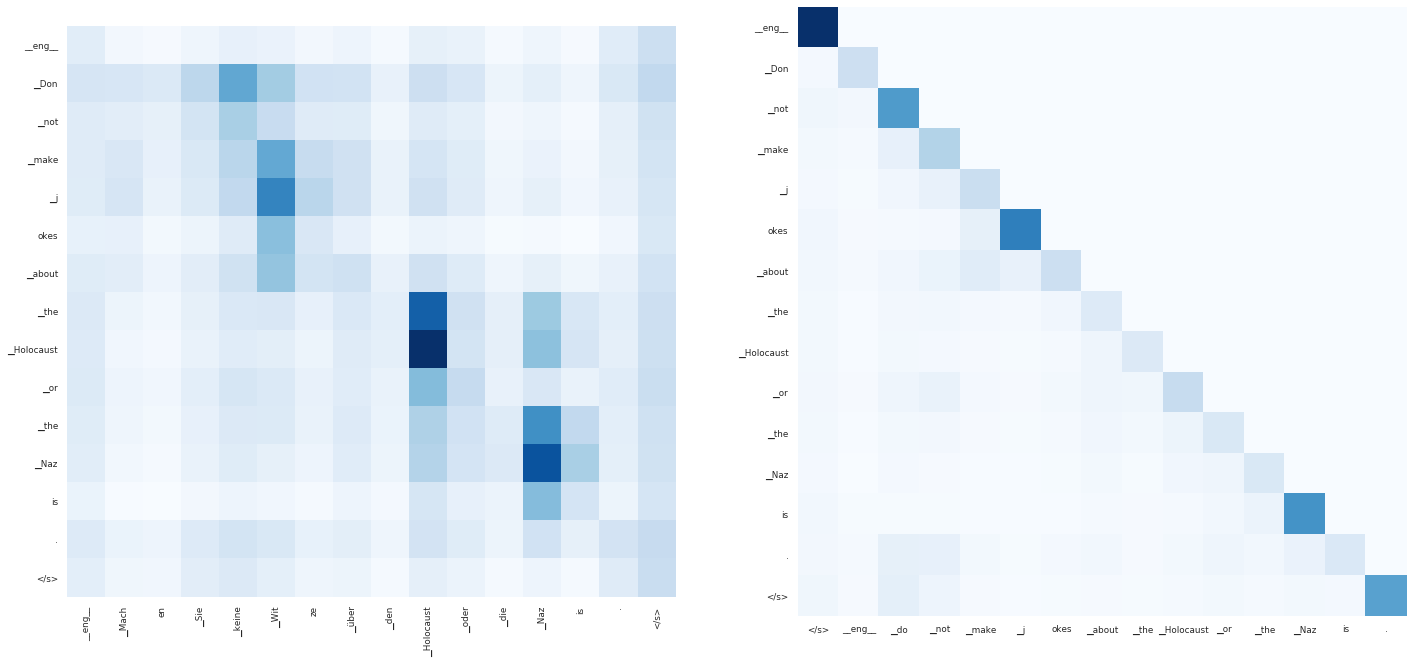

In [278]:
fig = plt.figure(figsize=(24, 14))
gs = GridSpec(1, 2)
gs.update(wspace=0.2, hspace=0.05)#0.015
ax_left = plt.subplot(gs[0, 0])
ax_right = plt.subplot(gs[0, 1])
df = pd.DataFrame(contributions_rollout_layer_np[:,:len(source_sentence)], columns = source_sentence, index = predicted_sentence)
sns.set(font_scale=1.2)
sns.heatmap(df,cmap="Blues",square=True,ax=ax_left,cbar=False)
df = pd.DataFrame(contributions_rollout_layer_np[:,len(source_sentence):len(source_sentence)+len(target_sentence)], columns = target_sentence, index = predicted_sentence)
sns.heatmap(df,cmap="Blues",square=True,ax=ax_right,cbar=False)
plt.gcf().subplots_adjust(bottom=0.2)


toxic=[26,27]
toxiccont.clear()
for i in toxic:
 toxiccont.append(df_src_contribution.src_contribution[i])




## Word-word alignments (source-target) from contributions

Currently only works for teacher forcing

In [17]:
src_tok_str = ' '.join(source_sentence[:-1])
src_word_sent = ''.join(source_sentence[:-1]).replace('▁', ' ')

In [18]:
tgt_tok_str = ' '.join(target_sentence[:-1])
tgt_word_sent = ''.join(target_sentence[:-1]).replace('▁', ' ')

In [19]:
contribution_pred_src = contributions_rollout_layer_np[:,:len(source_sentence)]
src_word_to_bpe = align.convert_bpe_word(src_tok_str, src_word_sent)
tgt_word_to_bpe = align.convert_bpe_word(tgt_tok_str, tgt_word_sent)
contributions_word_word = align.get_word_word_attention(contribution_pred_src, src_word_to_bpe, tgt_word_to_bpe, remove_EOS=False)
contributions_word_word.shape

(20, 21)

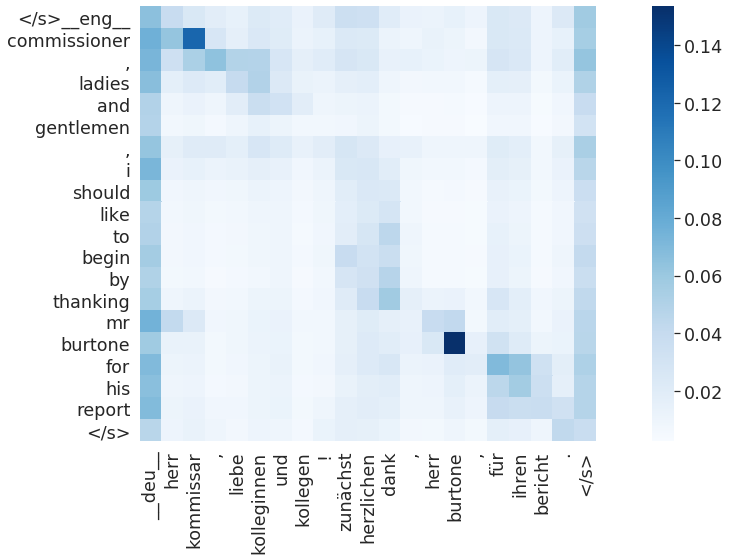

In [20]:
## Soft alignment
plt.figure(figsize=(20,8))
df = pd.DataFrame(contributions_word_word, columns = src_word_sent.split() + ['</s>'], index = tgt_word_sent.split() + ['</s>'])
sns.set(font_scale=1.6)
sns.heatmap(df,cmap="Blues",square=True,cbar=True);

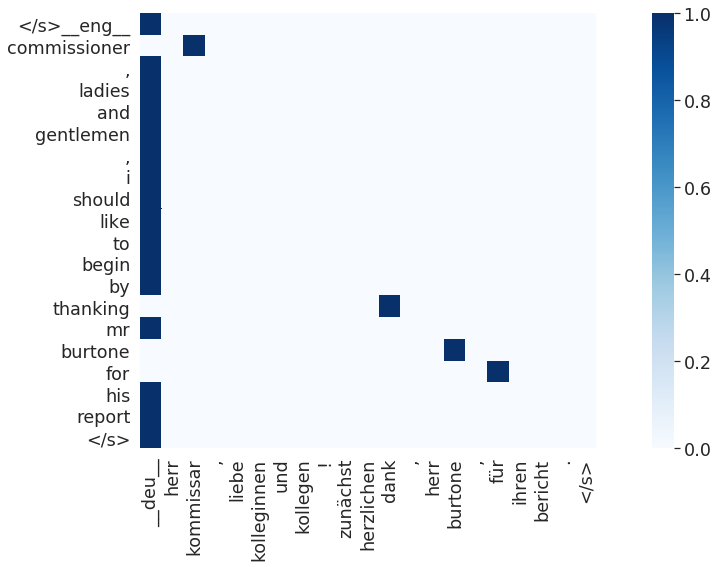

In [21]:
## Hard alignment
a_argmax = np.argmax(contributions_word_word, -1)
contributions_word_word_hard = np.zeros(contributions_word_word.shape)

for i, j in enumerate(a_argmax):
    contributions_word_word_hard[i][j] = 1

plt.figure(figsize=(20,8))
df = pd.DataFrame(contributions_word_word_hard, columns = src_word_sent.split() + ['</s>'], index = tgt_word_sent.split() + ['</s>'])
sns.set(font_scale=1.6)
sns.heatmap(df,cmap="Blues",square=True,cbar=True);